# Cars 4 You: Expending Car Evaluations with ML

**Group Member Contribution**:
*  Catarina Martins (n20221914)
*  Marta Ribeiro (n20221886)
*  Nicole Nogueira (n20221961)

**Abstract:**

kjbskajb

## 0. Identify business needs

## 1. Import the needed libraries

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import numpy as np
import os
from sklearn.metrics import make_scorer 
from sklearn.model_selection import PredefinedSplit

## 2. Data importation and integration

In [2]:
train_data = pd.read_csv('project_data/train.csv')
test_data = pd.read_csv('project_data/test.csv')

In [3]:
data= train_data.copy()

## 3. Data exploration and understanding
This stage of the notebook is intedent to visualize and understand the dataset we are later going to train the model (*data*). By extracting meaningful information about this dataset, we are able to indentify what needs to be modified in the next stage (data preparation). Therefore, we are going to overview the dataset *data*, check if there are duplicates, missing values and outliers as well as analyse the its variables' distribution and correlation. 

### Metadata
- *carID*: An attribute that contains an identifier for each car.
- *Brand*: The car’s main brand (e.g. Ford, Toyota).
- *model*: The car model.
- *year*: The year of Registration of the Car.
- *mileage*: The total reported distance travelled by the car (in
 miles).
- *tax*: The amount of road tax (in £) that, in 2020, was
 applicable to the car in question.
- *fuelType*: Type of Fuel used by the car (Diesel, Petrol, Hybrid,
 Electric).
- *mpg*: Average Miles per Gallon.
- *engineSize*: Size of Engine in liters (Cubic Decimeters).
- *paintQuality%*:  The mechanic’s assessment of the cars’ overall paint
 quality and hull integrity (filled by the mechanic
 during evaluation). 
- *previousOwners*: Number of previous registered owners of the vehicle.
- *hasDamage*:  Boolean marker filled by the seller at the time of
 registration stating whether the car is damaged or
 not.
- *price*: The car’s price when purchased by Cars 4 You (in £).

### 3.1. Data Overview

In [ ]:
#overview the dataset
data.info()

At first sight we can understand that: 
- Our data has 14 variables (columns), being 10 numerical variables (float and integers) and 4 non-numerical variables (strings). Moreover, one of the variables is *carID*, which is likely to be setted it to index, later on. 

- Besides all variables have observations, some of them like *tax* and *mpg* present less observations than the rest (a difference of almost 6500 obsrevations). This indicates that this variables present a considerable number of missing values, that should be addressed in data preparation. 

- The datatypes of *year* and *previousOwners* are stated as floats, however; these should be integers since it does not make sense to have half years or a third of an owner, for example. *hasDamage* should also be boolean instead of float, because according to metadata this variable is caracterized by a "Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not."

- According to the project's guideline, we should be able to "create a predictive model capable of evaluating the price of a car based on the user’s input without needing the car to be taken to a mechanic." and as *paintQuality%* is "The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation).", this variable is not considered either valid or accurate to predict the model. Therefore, this variable should not be considered in the model and it will be droped when handling incoherencies.

In [ ]:
#first 20 rows
data.head(20)

By acessing the 20 first rows of the data, we can observe that:

- There are some spelling mistakes in all categorical variables: some observations are 'for' instead of 'ford', anual' instead of 'manual' and 'etrol' instead of 'petrol', etc. This could not only compromise our visualizations (since there are many more categories that it should) but also turn our model biased (because there are different categories that explain the same information). Therefore, this mistakes should be addressed by grouping all the wrong categories and replacing them by the correct one.   

- The variable *previousOwners* that represents the number of previous registered owners of the vehicle, presents at least one negative value, which is impossible. In this dataset, this variable should only contain possitive numbers.  

- All observations of the first 20 rows of the variable 'hasDamage' are 0, which means that all these observations convey the same information, which is not going to be relevant for the model. 

In [ ]:
#last 20 rows
data.tail(20)

By acessing the 20 last rows of the data, we can see that the spelling mistakes identified in the first 20 rows continue to occur and the variable *hasDamage* remain with value 0 in all observations, which reinforces the fact that these must be modified. 

In [ ]:
#Descriptive statistics for numerical data
data.describe().T

For metric variables, we can analyse the descriptive statistics such as the mean, the minimum and maximum number, etc. We can observe that:

- The minimum number of *mileage* is negative which is wrong because a car cannot travel negative miles. The same thing happens with *tax*, *mpg*, *engineSize*, and *previousOwners*. These are incoherencies that must be addressed by replacing these values by missing values or valid numbers. 

- Not only, the maximum numbers of *previousOwners* and *year* are floats which is a mistake because these variables should only assume integer numbers, but also the maximum year is 2024, which is also a incoherencie because this dataset is from 2020. Similarly to the incoherencies spoted in the minimum values, these numbers should also be addressed by replacing them by missing values or valid numbers. 

- As expected, all observations of *hasDamage* are 0, which indicates that it does not add any relevant information to estimate the target. This variable should not be kept to predict the model.

- The *price* (our predictive variable) of most cars vary between 10000 and 21000, however; the minimum price is 450 while the maximum price is 159999, which indicates that the range of price is very large and there are both low and high value cars in this dataset. 

In [ ]:
#Descriptive statistics for categorical data
data.describe(include = ['O'])

For non-metric features, we can observe some relevant information like the number of unique values and the observations that appear the most in each variable. We can understand that:

- There are some missing values in these variables but not a considerable quantity. Nevertheless, these missing values should be filled in data preparation. 

- Besides there are only 72 different brands, there are 735 different models. We can not forget that these values are biased due to the spelling mistakes spoted before, which means that the quantity of unique values should be lower than showed. 

- The most frequent car in our dataset is a manual petrol ford focus, which is generally consider low- to mid-value car and in most used-car markets, it is positioned as affordable. 

In [4]:
#separate numerical and categorical features 

metric_features = ['year', 'mileage', 'tax', 'mpg',
                    'engineSize', 'previousOwners', 'hasDamage', 'price']

non_metric_features= ['Brand','model','transmission','fuelType']


In [ ]:
#checking what are the unique values of categorical variables
for col in non_metric_features:
    print(f"\nColumn: {col}")
    print(data[col].unique())

As expected, most of the unique values are spelling mistakes, probably done during data collection. After handling incoherencies, the categories of these varibales should be highly less than observed now. 

### 3.2. Checking Duplicates

In [ ]:
#Number of duplicates
data.duplicated().sum()

The current dataset does not present duplicated, however; these should be chacked again after handling incoherencies present in our data, because it is possible that some duplicates will appear once we group same categories of variables such as *model* or *brand*, or remove *paintQuality%* from the dataset. 

### 3.3. Checking Missing Values

In [ ]:
#Number of missing values
data.isna().sum()

In [ ]:
#Number of missing values in each column as a percentage
data.isna().sum()/len(data) * 100

The variables that have present a higher number of missing values are *tax* and *mpg*. The rest of them have basically the same number of missing values, excluding *carId* and *price* (target) that have no missing values. The fact that these two variables do not present missing values is a good sign: it means that we can use *carId* as an index and that we can use all of our observations to build the model since all of them has the variable *price* filled. 

Taking into account the total number of observations, it is possible to see that, the majority of missing values vary between 1 and 2 percentage in each variable, which is not too high. The higher percentages are 10.40 and 10.43, belonging to *tax* and *mpg*, respectively. Therefore, we need to be aware to use a method good enough to fill these missing values without creating bias. 

### 3.4. Checking Numerical Variables

#### 3.4.1. Checking Outliers

In [5]:
# Checking outliers of numerical variables through the visualization of boxplots

def plot_multiple_boxplots(data, feats, title="Numeric Variables' Box Plots"):

    # Prepare figure. Create individual axes where each histogram will be placed
    fig, axes = plt.subplots(4, ceil(len(feats) / 4), figsize=(40, 30))

    # Plot data
    # Iterate across axes objects and associate each histogram:
    for ax, feat in zip(axes.flatten(), feats):
        sns.boxplot(x=data[feat], ax=ax, color="#5dade2")
        ax.set_title(feat)

    # Layout
    plt.suptitle(title)
    plt.show()

    return

In [ ]:
plot_multiple_boxplots(data, metric_features)

Through the visual representation of the IQR method, it is possible to understand that:
- There are a considerable number of outliers in all variables, except for *previousOwners* and *hasDamage*, and most of the variables present strong right-skewness, which might affect modelling. This problem needs to be addressed through the delimitation of small ranges.
- In *mileage*, *mpg*, *engineSize*, *previousOwners*, the negative outliers are also incoherences that need to be handled.
- We must have a special attention to the variables *mpg* and *tax*. Due to their considerble number of missing values, the method of manually removing outliers might not be the best option beacause the percentage of observations removed would be higher than 3% (the usual recommended value). Therefore, we are probably using other method to keep the same amount of observations. 
- The majority of cars have the price in the lower to mid range, but there is a long tail extending toward very high prices. This indicates that low–mid priced cars are very common and that high-priced or luxury cars are rare but still present, as well as the distribution is not symmetric. Besides this being a possible problem when modelling, we have decided to not alter the variable *price* since even though there are extreme values, these represent a category of cars that we might have to predict with our model. 
 

#### 3.4.2. Checking Distributions

In [ ]:
df= pd.DataFrame(data[metric_features])

In [ ]:
# Creating histograms to see the distribrution of numerical variables

num_cols = df.select_dtypes(include=['number']).columns
n = len(num_cols)

# Adjust layout
fig, axes = plt.subplots(nrows=(n // 3) + 1, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=20, color='#5dade2', edgecolor='black')  
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('frequency')

# Remove empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

 As previously identified in the boxplots, most variables are skewed either to the left (*year*) or to the right (*mileage*). For that reason, it is important to pay attention to what models to use when training because some of them might be affected by skewed features. Nevertheless, we have decided to not apply any transformation (such as log or square root transformations) to these features since it would difficult the interpretability of the model and due to the fact skewness does not necessarily harm predictive power.

### 3.5. Checking Categorical Variables

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

# Create a function that generates a palette with as many colors as needed
def get_palette(data, column):
    n = data[column].nunique()
    return sns.color_palette("tab20", n) if n <= 20 else sns.color_palette("husl", n)

# Create 4 subplots
fig, ax = plt.subplots(nrows=4, ncols=1, dpi=300, figsize=(20, 40))
fig.patch.set_facecolor('white')

# Plot each variable
cols = ['Brand', 'model', 'transmission', 'fuelType']

for i, col in enumerate(cols):
    palette = get_palette(test_data, col)
    sns.countplot(data=test_data,
                  x=col,
                  hue=col,            # required to use palette in seaborn 0.14+
                  legend=False,       # hide duplicated legend
                  palette=palette,
                  ax=ax[i])
    ax[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Since there is a high amount of categories in categorical data due to the existance of spelling mistakes, the bar charts created would not give us reliable or interpretable insights.Despite that, we can observe that, before correcting the spelling mistakes, *Ford* is the brand that stand outs the most, while more than 16000 cars are manual and also more than 16000 cars are petrol, followed by diesel cars with almost 13000 observation. Regarding the variable *model*, its categories could not be understood because they are more that 700, therefore it is only possible to retrieve insights after handling these incoherences. 


### 3.6. Checking Correlation between Variables

In [ ]:
# Check correlation between variables 
# We are going to use spearman correlation since our variables do not follow a normal distribution
cor_spearman = data[metric_features].corr(method ='spearman')
cor_spearman

In [ ]:
# Create correlation matrix to facilitate interpretation

def cor_heatmap(cor):
    plt.figure(figsize=(12, 10))

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(cor, dtype=bool))

    # Plot heatmap 
    sns.heatmap(
        data=cor,
        mask=mask,
        annot=True,
        cmap='YlGnBu',   
        fmt='.2f',
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
    )

    plt.title("Spearman Correlation Matrix", fontsize=14)
    plt.show()

In [ ]:
cor_heatmap(cor_spearman)

- The higher correlation in our dataset is -0.78 and it is between *mileage* and *year*. This value make sense because the newer the car (higher the year) the less miles it would travalled (less the mileage). 
- The next most higher correlation after *mileage* and *year* is positive and it is between the target variable (*price*) and *year*, with 0.6, followed by 0.56 correlation between *engineSize* and *price*. This indicates that the newer the car, the expensive it becomes and that expensive cars usually hava a bigger engine, which follows the usual patterns of used cars markets.
- Moreover, we can understand that *hasDamaged* presents no values at all due to the fact that its variance is zero hence its correlation with other variables are undefined, while *previousOwners* has a null relationship with all other features including *price*, which is an indicator is irrelavance for trainig the model and predicting price. 

In [ ]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot and use historgrams in the diagonal
sns.pairplot(df[metric_features], diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

# Create eda directory 
if not os.path.exists(os.path.join('..', 'figures', 'eda')):
    os.makedirs(os.path.join('..', 'figures', 'eda'))
    
plt.savefig(os.path.join('..', 'figures', 'eda', 'pairwise_numeric_scatterplots.png'), dpi=200)
plt.show()

As a complement of the correlation matrix, the pairplot help us to better visualize the relationships between numerical variables. Overall, the scatterplots do not present clear linear patterns, indicating that most variable pairs show weak or non-linear associations. Enven tough the correlation matrix revealed a strong negative correlation between the variables *year* and *mileage*, this pairplot suggests a considerable amount of dispersion around any potential trend, implying that the relationship is not strictly linear. 

## 4. Data preparation
This stage of the notebook has the objective of preparing the dataset to train the model. This preparation includes correcting the existent mistakes spotted in the previous step, such as handling incoherencies, removing duplicates, dealing with outliers and filling missing values, as well as encoding and scalling features. At the end, we will be able to select a group of variables and train the model to predict our target variable.

It is importante to note that the *test* dataset (the dataset we need to make prediction) will be modified along with *data* as a way to facilitate its data preparation.

### 4.1. Set index

In [6]:
# Set index to CarID 
data.set_index('carID', inplace = True)
test_data.set_index('carID', inplace = True)

Since *carID* has no missing values (meaning all cars have a *carID*) and has no duplicates (meaning each car has its own unique inditifier), we have decided to set this feature to index in order to uniquely identify each row and improving data referencing.

### 4.2. Slipt the data into train and validation dataset

#### The Hold Out Method
In order to understand if a predictive model works, we need to be able to evaluate how it performs. Therefore, we are going to split the dataset (*data*) into *train* and *validation* using *The Hold Out Method* because not only this method it is efficient and simple to implement but also due to the nature of our dataset, that is characterized by being large and approximately i.i.d. 
To apply this method, we first seperated the price (target festure) from the original dataset and then split the remaining data into **X_val** (30% of *data*) and **X_train** (70% of *data*). From this point onward, both *X_train* and *X_val* will be modified in each stage, with preprocessing techniques being fit on *X_train* and then applied (transformed) to *X_val* to prevent data leakage. 

**Note** that the *test* dataset does not need to be splited. 

In [7]:
X = data.drop('price', axis = 1) # In X, the target variable will be removed and the dataset will be used as the training set
y = data['price']  # y corresponds to the target variable

In [8]:
# Splits the dataset

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3,  # 30% will be used for validation 
                                                  random_state = 0,      # Ensures the split is always the same every time the code runs
                                                  shuffle = True)        # Shuffles the data before spliting to avoid bias

### 4.3. Changing datatypes
It did not make sense for *year*, *previousOwners* and *hasDamage* to be floats, so we have decided to change their datatype to integer. Note that, we previously stated that *hasDamaged* should be a boolean, however; a feature cannot change its datatype to *bool* if it has missing values. In this way, it was changed to *int8*, where 0 corresponds to "False" and 1 corresponds to "True".

In [9]:
# Rounds the floats and changes them to integers

#year to integer
X_train['year'] = X_train['year'].round().astype('Int32')
X_val['year'] = X_val['year'].round().astype('Int32')
test_data['year'] = test_data['year'].round().astype('Int32')

#previousOwners to integer
X_train['previousOwners'] = X_train['previousOwners'].round().astype('Int32')
X_val['previousOwners'] = X_val['previousOwners'].round().astype('Int32')
test_data['previousOwners'] = test_data['previousOwners'].round().astype('Int32')

#hasDamaged to boolean
X_train['hasDamage'] = X_train['hasDamage'].astype('Int8')
X_val['hasDamage'] = X_val['hasDamage'].astype('Int8')
test_data['hasDamage'] = test_data['hasDamage'].astype('Int8')

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53181 entries, 42520 to 15659
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           52128 non-null  object 
 1   model           52136 non-null  object 
 2   year            52130 non-null  Int32  
 3   transmission    52086 non-null  object 
 4   mileage         52157 non-null  float64
 5   fuelType        52160 non-null  object 
 6   tax             47671 non-null  float64
 7   mpg             47683 non-null  float64
 8   engineSize      52118 non-null  float64
 9   paintQuality%   52091 non-null  float64
 10  previousOwners  52090 non-null  Int32  
 11  hasDamage       52087 non-null  Int8   
dtypes: Int32(2), Int8(1), float64(5), object(4)
memory usage: 4.7+ MB


In [11]:
X_train.head()

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
42520,Mercedes,E Class,2018,Semi-Auto,1306.0,Diesel,145.0,41.5,3.0,55.0,3,0
25115,Ford,Focus,2015,Automatic,7802.0,petrol,NaN,NaN,1.6,65.0,2,0
45113,Mercedes,C Class,2017,Automatic,18495.0,Diesel,NaN,NaN,2.1,96.0,4,0
34623,Hyundai,IX20,2018,Manual,6684.0,Petrol,150.0,50.4,1.4,51.0,3,0
66409,VW,Gol,2019,Automatic,12617.0,ETROL,145.0,37.7,2.0,54.0,3,0


### 4.4. Handling Incoherencies

#### 4.4.1. Categorical Variables 

##### 4.4.1.1. Correcting Spelling Mistakes
We have corrected the spealling mistakes of categorical variables by grouping all the wrong categories and allocating them to the most similiar correct one. This process was realized considering the logic of having the first letter of the category in upper case followed by the remain letters in lower case. In case of *model*, there were some categories that did not necessarily correspond to a real model, but these incoherencies would be verified in the next stage. 

In [12]:
#correcting spelling mistakes of 'brand' for X_train, X_val and test_data

correct_brand = {
    'VW': ['V', 'vw', 'v', 'W', 'w'],
    'Toyota': ['Toyot', 'TOYOTA', 'oyota', 'toyota', 'OYOTA', 'TOYOT', 'toyot', 'oyot'],
    'Audi': ['udi', 'AUDI', 'audi', 'Aud', 'aud', 'UDI', 'AUD'],
    'Ford': ['FOR', 'ord', 'For', 'FORD', 'ford', 'for', 'or', 'ORD'],
    'BMW': ['MW', 'bmw', 'BM', 'mw', 'M', 'bm'],
    'Skoda': ['koda', 'skoda', 'SKODA', 'Skod', 'kod', 'SKOD', 'KODA', 'skod'],
    'Opel': ['Ope', 'opel', 'pel', 'pe', 'OPEL', 'PEL', 'OPE', 'ope'],
    'Mercedes': ['mercedes', 'Mercede', 'MERCEDES', 'ercedes', 'mercede', 'ERCEDES', 'ercede', 'MERCEDE'],
    'Hyundai': ['yundai', 'Hyunda', 'hyundai', 'HYUNDAI', 'yunda', 'HYUNDA', 'ud', 'hyunda', 'YUNDAI']
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_brand.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["Brand"] = X_train["Brand"].replace(replacement_dict)
X_val["Brand"] = X_val["Brand"].replace(replacement_dict)
test_data["Brand"] = test_data["Brand"].replace(replacement_dict)

# Verify the cleaning
print(X_train["Brand"].unique())
print(X_val["Brand"].unique())
print(test_data["Brand"].unique())

['Mercedes' 'Ford' 'Hyundai' 'VW' 'Opel' 'Audi' 'Toyota' 'BMW' nan 'Skoda']
['Mercedes' 'Opel' 'Ford' 'VW' 'Toyota' nan 'BMW' 'Skoda' 'Audi' 'Hyundai']
['Hyundai' 'VW' 'BMW' 'Opel' 'Ford' 'Mercedes' 'Skoda' 'Toyota' 'Audi' nan]


In [13]:
##correcting spelling mistakes of 'model' for X_train, X_val and test_data

correct_model = {
    'Golf': [' GOLF', ' Gol', ' golf', 'golf', ' Golf', ' gol', ' GOL', 'Gol', 'GOLF'],
    'Yaris': [' Yaris', ' YARIS', ' Yari', ' yaris', ' yari', 'Yari', ' YARI', 'yaris', 'YARIS'],
    'Q2': [' q2', ' Q2'],
    '2 Series': [' 2 series', ' 2 serie', '2 Series', ' 2 SERIES', ' 2 Serie', '2 Serie', ' 2 Series'],
    '3 Series': [' 3 Series', ' 3 Serie', ' 3 series', ' 3 SERIES', ' 3 serie', '3 Serie'],
    'A3': [' A3', ' a3'],
    'Octavia': [' Octavi', ' OCTAVIA', ' Octavia', ' octavia', 'Octavi', 'octavia', ' octavi', ' OCTAVI'],
    'Passat': [' PASSAT', ' passat', ' Passa', 'Passat', ' Passat', 'PASSAT', ' PASSA'],
    'Insignia': [' Insigni', ' INSIGNIA', ' insignia', ' Insignia', ' INSIGNI', 'Insigni'],
    'Fabia': [' Fabia', ' fabia', ' FABIA', ' Fabi', 'FABIA'],
    'A Class': [' A Clas', ' A Class', ' a class', ' A CLASS', 'a class', 'A CLASS', ' a clas'],
    'Ka+': [' Ka+', ' KA+', ' ka+', 'ka+'],
    'GLC Class': [' GLC Class', ' GLC CLASS', ' GLC Clas', ' glc class', ' glc clas'], 
    'I30': [' i30', ' I30'],
    'C Class': [' C Clas', ' C CLASS', ' c class', 'C Clas', ' C CLAS', 'c class', ' c clas', ' C Class', 'C CLASS'],
    'Polo': [' POLO', ' Polo', ' polo', ' Pol', ' POL', 'Pol', 'POLO'],
    'E Class': [' E Class', ' E Clas', ' E CLASS', ' e class', 'E CLASS', 'e class'],
    'Q5': [' Q5', ' q5', 'q5'],
    'Up': ['U', ' up', ' UP', ' Up', ' U', 'UP'],
    'Fiesta': [' FIESTA', ' fiesta', ' Fiest', ' Fiesta', 'fiesta', 'Fiest', ' FIESTA', 'FIESTA', ' fiest'],
    'C-HR': [' C-H', ' c-hr', ' C-HR', ' c-h'],
    'Mokka X': [' mokka x', ' MOKKA X', ' Mokka X'],
    'Corsa': [' Corsa', ' corsa', ' Cors', ' CORSA', ' cors', ' CORS', 'corsa'],
    'Astra': [' ASTRA', ' Astr', ' Astra', ' astra', 'ASTRA', 'astra'],
    'TT': [' tt', ' TT', ' T'],
    '5 Series': [' 5 Series', ' 5 Serie', ' 5 SERIES', ' 5 series', '5 SERIES', ' 5 SERIE'],
    'Aygo': [' aygo', ' ayg', ' AYGO', ' Ayg', ' Aygo', 'aygo', ' AYG'],
    '4 Series': [' 4 SERIES', ' 4 Serie', ' 4 serie', '4 series', '4 Series', ' 4 Series', ' 4 series'],
    'SLK': [' slk', ' SLK'],
    'Viva': [' viva', ' Viva', ' VIVA', ' Viv', 'viva'],
    'Focus': [' Focus', ' Focu', ' FOCUS', ' focus', ' FOCU', 'focus', 'Focu', ' focu', 'FOCUS'],
    'EcoSport': [' EcoSpor', ' ECOSPORT', ' ecosport', ' EcoSport'],
    'X-CLASS': [' x-clas', ' X-CLAS', ' x-class', ' X-CLASS'],
    'CL Class': [' cl class', ' CL Clas', ' CL CLASS', ' CL Class'],
    'IX20': [' ix20', ' IX20'],
    'Rapid': [' Rapi', ' rapid', ' Rapid'],
    'Auris': [' Auris', ' AURIS', ' auris', ' Auri'],
    'I20': [' i20', ' I20'],
    'X3': [' x3', ' X3'],
    'A8': [' A8', 'a8'],
    'GLS Class': [' GLS Clas', ' GLS CLASS', ' gls class', ' GLS Class'],
    'B-MAX': [' B-MA', ' B-MAX', 'B-MA', ' b-max'],
    'A4': [' A4', ' a4'],
    'Kona': [' KONA', ' Kon', ' Kona', ' KON', ' kona'],
    'I10': [' i10', ' I10'],
    'A1': [' A1', ' a1'],
    'Mokka': [' Mokka ', ' Mokk', ' Mokka', ' mokka ', ' mokka', ' MOKKA', 'Mokka ', 'Mokk'],
    'S-MAX': [' S-MA', ' s-max', ' S-MAX', ' s-ma'],
    'X2': [' x2', ' X2'],
    'Crossland X': [' crossland x', ' CROSSLAND X', ' Crossland X'],
    'Tiguan': [' Tiguan', ' tiguan', ' Tigua', ' TIGUAN', ' TIGUA', 'Tigua', 'TIGUAN', 'tiguan', ' tigua'],
    'A5': [' A5', ' a5', 'a5'],
    'GLE Class': [' GLE Clas', ' GLE Class', ' gle class', ' GLE CLASS'],
    'Zafira': [' Zafira', ' Zafir', ' ZAFIRA', ' zafira', 'Zafir', ' ZAFIR'],
    'Ioniq': [' Ioni', ' Ioniq', ' IONIQ', 'IONIQ', ' ioniq'],
    'A6': [' A6', ' a6'],
    'Yeti Outdoor': [' yeti outdoor', ' Yeti Outdoor', ' YETI OUTDOOR', ' Yeti Outdoo', ' yeti outdoor', 'yeti outdoor', ' yeti outdoo'],
    'X1': [' x1', 'x1', ' X1'],
    'Scala': [' SCALA', ' Scala', ' scala', ' Scal', ' scal'],
    'S Class': [' S Class', ' S Clas', ' s class', ' S CLASS'],
    '1 Series': [' 1 Series', ' 1 SERIES', ' 1 Serie', ' 1 series', '1 SERIES', ' 1 SERIE', '1 series', ' 1 serie'],
    'Kamiq': [' KAMIQ', ' KAMI', ' kamiq', ' Kamiq'],
    'Kuga': [' Kug', ' KUGA', ' kuga', 'Kuga', ' Kuga', 'kuga'],
    'Tourneo Connect': [' tourneo connect', ' Tourneo Connect'],
    'Q7': [' q7', ' Q7'],
    'GLA Class': [' GLA Class', ' GLA CLASS', ' GLA Clas', ' gla class'],
    'Arteon': [' arteon', ' Arteon', ' Arteon'],
    'SL CLASS': [' SL CLAS', ' SL CLASS', ' sl class', ' SL'],
    'Tucson': [' Tucson', ' TUCSON', ' Tucso', ' tucson', ' TUCSO', 'Tucso'],
    'Santa Fe': [' Santa F', ' santa fe', ' SANTA FE', ' Santa Fe'],
    'Grandland X': [' Grandland X', ' grandland x', ' GRANDLAND X'],
    'RAV4': [' rav4', 'RAV4', 'RAV', ' RAV', 'rav4', ' rav', ' RAV4'],
    'Touran': [' Touran', 'Toura', ' TOURAN', ' touran', ' Toura', ' TOURA'],
    'Citigo': [' Citig', ' citigo', ' Citigo', ' CITIGO', 'CITIGO'],
    'Roomster': [' Roomste', ' Roomster'],
    'Prius': [' PRIUS', ' Prius', 'Prius', ' prius'],
    'Corolla': [' corolla', ' COROLLA', ' Coroll', ' Corolla', 'corolla'],
    'B Class': [' b class', ' B Clas', ' B Class', ' B CLASS', 'b class'],
    'Sharan': [' sharan', ' Shara', ' Sharan', ' SHARAN'],
    'Kodiaq': [' Kodia', ' kodiaq', 'kodiaq', ' KODIAQ', ' Kodiaq'],
    'V Class': [' V Clas', ' V CLASS', ' V Class', ' v class'],
    'Caddy Maxi Life': [' Caddy Maxi Lif', ' Caddy Maxi Life'],
    'Superb': [' Superb', ' Super', ' SUPERB', ' superb', ' super'],
    'T-Roc': [' T-Roc', ' T-RO', ' t-roc', ' T-Ro', ' T-ROC'],
    'Combo Life': [' COMBO LIFE', ' combo life', ' Combo Lif', 'COMBO LIFE', ' Combo Life'],
    'Beetle': [' Beetl', ' Beetle', ' beetle'],
    'Galaxy': [' GALAXY', ' Galax', ' galaxy', ' Galaxy'],
    'M3': [' M3', ' m3'],
    'Gtc': [' gtc', ' GTC', ' gtc', 'gtc', 'GTC'],
    'X4': [' X4', ' x4'],
    'KA': [' Ka', ' ka', ' K', ' KA'],
    'IX35': [' ix35', ' IX35'],
    'Grand Tourneo Connect': [' Grand Tourneo Connec', ' Grand Tourneo Connect'],
    'M4': [' m4', ' M4'],
    'Tourneo Custom': [' tourneo custom', ' Tourneo Custo', ' Tourneo Custom'],
    'Z4': [' Z4', ' z4'],
    'X5': [' X5', ' x5'],
    'Meriva': [' Meriva', ' MERIVA', ' Meriv', ' meriva'],
    'RS6': [' RS6'],
    'Verso': [' VERSO', ' verso', ' Verso', ' Vers'],
    'Touareg': [' Touareg', ' TOUAREG', ' touareg', ' Touare'],
    'Mondeo': [' MONDEO', ' Mondeo', ' mondeo', ' MONDE', ' Monde'],
    'Shuttle': [' shuttle', ' Shuttle', ' SHUTTLE'],
    'CLS Class': [' CLS Class', ' cls class', ' CLS Clas', ' CLS CLASS'], 
    'C-MAX': [' C-MAX', ' c-max', ' C-MA'],
    'Puma': [' puma', ' PUMA', ' Puma', 'Pum', ' Pum'],
    'CLA Class': [' CLA Class', ' CLA CLASS', ' cla class', ' CLA Clas'],
    'I40': [' I40', ' i40'],
    'Q3': [' q3', ' Q3'],
    'Tiguan Allspace': [' TIGUAN ALLSPACE', ' tiguan allspace', ' Tiguan Allspac', ' Tiguan Allspace'],
    '6 Series': [' 6 SERIES', ' 6 series', ' 6 Series', ' 6 Serie'],
    'Caravelle': [' caravelle', ' Caravell', ' Caravelle'],
    'Karoq': [' Karoq', ' karoq', ' KAROQ', ' Karo'],
    'I3': [' i3', 'i3', ' I3'],
    'Grand C-MAX': [' GRAND C-MAX', ' grand c-max', ' Grand C-MA', ' Grand C-MAX'],
    'T-Cross': [' T-Cros', ' T-CROSS', ' T-Cross', ' t-cros', ' t-cross'],
    'A7': [' a7', ' A7'],
    'Golf SV': [' Golf SV', ' golf sv', ' GOLF SV'],
    'A': [' a', ' A'],
    'GT86': [' gt86', ' GT86'],
    'Yeti': [' yeti', ' Yet', ' Yeti', ' YETI'],
    'X': [' x', ' X'],
    'Land Cruiser': [' Land Cruise', ' Land Cruiser', ' land cruiser'],
    'EDGE': [' Edge', ' edge', ' Edg', ' EDGE'],
    'X6': [' X6'],
    'Fusion': [' Fusion', ' fusion'],
    'GL Class': [' GL CLASS', ' gl class', ' GL Class', ' GL Clas'],
    'Scirocco': [' scirocco', ' SCIROCCO', ' Scirocc', ' Scirocco'],
    'Z3': [' Z3'],
    'Hilux': [' hilux', ' Hilux', ' Hilu', ' HILU'],
    'Amarok': [' amarok', ' Amarok', ' Amaro'],
    'CC': [' cc', ' CC'],
    '7 Series': [' 7 Serie', ' 7 SERIES', ' 7 series', ' 7 Series'],
    'Avensis': [' AVENSIS', ' avensis', ' Avensis'],
    'M Class': [' m class', ' M CLASS', ' M Class', ' M Clas', ' M CLAS'],
    'Grandland': [' grandland ', ' Grandland '],
    'Zafira Tourer': [' Zafira Toure', ' ZAFIRA TOURER', ' Zafira Tourer', ' zafira tourer'],
    'R8': [' R8', ' r8'],
    'Mustang': [' mustang', ' Mustang'],
    'Q8': [' Q8'],
    'CLK': [' CLK'],
    'RS3': [' RS3'],
    'Jetta': [' JETTA', ' Jetta', ' jetta', 'Jetta' ],
    'Supra': [' Supra'],
    'X7': [' X7'],
    'SQ7': [' SQ7', ' sq7'],
    'S3': [' s3', ' S3'],
    'Arteon': [' Arteo', 'Arteo', ' ARTEON', ' arteon', ' Arteon'],
    'GLB Class': [' glb class', ' GLB Class'],
    'Adam': [' Ada', ' adam', ' ADAM', ' Adam'],
    'M5': [' M5',' m5'],
    'Golf S': [' golf s', ' Golf S'],
    'Vectra': ['Vectra', ' Vectra', ' VECTRA', 'VECTRA'],
    '8 Series': [' 8 SERIES', ' 8 Serie', ' 8 Series', ' 8 series'],
    'Urban Cruiser': [' Urban Cruise', ' Urban Cruiser'],
    'Fox': ['fox', ' fox', ' Fox'], 
    'Q': [' Q'], 
    'M2': [' M2'], 
    'RS4':[' RS4'], 
    'Veloster': [' Veloster', ' Veloste'],  
    'IQ': [' IQ'], 
    'Agila': [' AGILA', ' Agila'], 
    'I2': [' I2'], 
    'Antara': [' Antara', ' antara'], 
    'G Class': [' G Class', ' G CLAS'], 
    'Caddy Life': [' Caddy Life', ' Caddy'],
    'R Class': [' R Class'], 
    'I800': [' I800'],
    'Amica': [' Amica'], 
    'Crossland': [' Crossland '],
    'Proace Verso': [' proace verso', ' PROACE VERSO', 'PROACE VERSO'],
    'Camry': [' Camry', 'Camry', ' Camr'], 
    'Tigra': [' Tigra'], 
    'Eos': [' Eos'], 
    'M': [' M'],
    'California': [' Californi', ' California'], 
    'Ampera': [' Ampera'], 
    'I1': [' I1'], 
    'S5': [' S5'], 
    'CLC Class': [' CLC Class'], 
    'Shara': [' SHARA'], 
    'I8': [' i8', 'i8'], 
    'RS7': [' RS7'], 
    'Transit Tourneo': [' Transit Tourneo'], 
    'I4': [' I4'], 
    'S4':[' S4'], 
    'Terracan': [' Terracan'], 
    'Cascada': [' Cascada'], 
    'S8': [' S8'], 
    'A2':[' A2'], 
    'Vivaro':[' Vivaro'],
    'RS5':[' RS5'],
    'SQ5':[' SQ5'], 
    'Getz':[' Getz'], 
    'M6':[' M6'], 
    'Caddy Maxi': [' Caddy Maxi'], 
    'Z':[' Z'], 
    'Verso-S': [' Verso-S'], 
    'Kadjar': [' Kadjar'], 
    'I80': [' I80'], 
    'Streetka': [' Streetka'],
    'RS': [' RS'], 
    'I': [' i'], 
    'Ranger': [' Ranger'], 
    'IX2': [' IX2'], 
    'Escort': [' Escort'],
    'Accent': [' Accent']
}


# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_model.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["model"] = X_train["model"].replace(replacement_dict)
X_val["model"] = X_val["model"].replace(replacement_dict)
test_data["model"] = test_data["model"].replace(replacement_dict)

# Verify the cleaning
print(X_train["model"].unique())
print(X_val["model"].unique())
print(test_data["model"].unique())

['E Class' 'Focus' 'C Class' 'IX20' 'Golf' 'I10' 'T-Cross' 'Corsa' 'A4'
 'Polo' 'Tucson' 'Kuga' 'Corolla' 'Yaris' 'Q3' 'A Class' 'A1' 'A5' 'Q5'
 'GLE Class' '3 Series' 'Fiesta' 'T-Roc' 'Insignia' 'GLC Class' 'X1'
 'Astra' 'Q2' 'Aygo' 'C-MAX' 'Q' '2 Series' 'A3' 'Touran' 'TT' 'Santa Fe'
 'C-HR' 'Superb' 'EDGE' 'S Class' 'CL Class' 'Ka+' 'Octavia' 'Arteon' 'X4'
 'Z4' nan 'EcoSport' 'Yeti Outdoor' 'Meriva' 'I20' 'Hilux' 'X5' 'M4'
 'CLA Class' '1 Series' 'Mokka X' 'Prius' 'X2' '4 Series' 'S4' 'Fabia'
 'Auris' 'Galaxy' 'Citigo' 'A6' 'RAV4' 'Passat' 'Grand C-MAX' 'Adam'
 'GLA Class' 'G Class' 'Zafira' 'Touareg' 'Sharan' 'Mokka' 'Tiguan'
 'Ioniq' 'Q7' 'Viva' 'X3' 'Tiguan Allspace' 'B Class' 'Up' 'Crossland X'
 'CLS Class' 'SLK' 'Kodiaq' 'Mondeo' 'B-MAX' 'Caddy Life' 'SL CLASS' 'A7'
 'A' 'I30' 'Yeti' 'Grandland X' 'Tourneo Custom' 'Antara' 'Avensis' 'X6'
 '5 Series' 'GL Class' 'IX35' 'Kamiq' 'KA' 'Caravelle' 'Karoq' 'Scala'
 'V Class' 'Golf SV' 'Verso' 'Kona' '7 Series' '6 Series' 'SQ7' 'Golf 

In [14]:
##correcting spelling mistakes of 'transmission' for X_train, X_val and test_data

correct_transmission = {
    'Semi-Auto': ['Semi-Aut', 'semi-auto', 'emi-Auto', 'SEMI-AUTO', 'SEMI-AUT', 'EMI-AUTO', 'emi-Aut', 'emi-auto', 'semi-aut'],
    'Manual': ['anual', 'manual', 'Manua', 'MANUAL', ' Manual ', 'ANUAL', 'manua', 'anua', 'MANUA', ' manual ', ' MANUAL ', ' Manual', 'Manual ', 'manual '],
    'Automatic': ['AUTOMATIC', 'automatic', 'Automati', 'utomatic', 'UTOMATIC', 'automati', 'AUTOMATI', 'utomati'],
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_transmission.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["transmission"] = X_train["transmission"].replace(replacement_dict)
X_val["transmission"] = X_val["transmission"].replace(replacement_dict)
test_data["transmission"] = test_data["transmission"].replace(replacement_dict)

#replacing the 'unknown' and 'other' variable with a missing value
X_train["transmission"] = X_train["transmission"].replace(['unknow','UNKNOWN','nknown','nknow', 'unknown', 'Other'], np.nan)
X_val["transmission"] = X_val["transmission"].replace(['unknow','UNKNOWN','nknown','nknow', 'unknown', 'Other'], np.nan)
test_data["transmission"] = test_data["transmission"].replace(['unknow','UNKNOWN','nknown','nknow', 'unknown', 'Other'], np.nan)

# Verify the cleaning
print(X_train["transmission"].unique())
print(X_val["transmission"].unique())
print(test_data["transmission"].unique())

['Semi-Auto' 'Automatic' 'Manual' nan]
['Semi-Auto' 'Manual' nan 'Automatic']
['Automatic' 'Semi-Auto' 'Manual' nan]


In [15]:
##correcting spelling mistakes of 'fuelType' for X_train, X_val and test_data

correct_fuelType = {
    'Petrol': ['etrol', 'petrol', 'PETROL', 'Petro', 'petro', 'ETROL', 'PETRO', 'etro', 'ETRO'],
    'Diesel': ['diesel','iesel','Diese','DIESEL','DIESE','IESEL','iese','diese','IESE'],
    'Hybrid': ['HYBRID','ybri','Hybri','ybrid','hybrid','YBRID','HYBRI', 'hybri'],
    'Other': ['ther','Othe','OTHER','other']
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_fuelType.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["fuelType"] = X_train["fuelType"].replace(replacement_dict)
X_val["fuelType"] = X_val["fuelType"].replace(replacement_dict)
test_data["fuelType"] = test_data["fuelType"].replace(replacement_dict)

#replacing the 'other' variable with a missing value 
X_train["fuelType"] = X_train["fuelType"].replace(['ther','Othe','OTHER','other', 'Other'], np.nan)
X_val["fuelType"] = X_val["fuelType"].replace(['ther','Othe','OTHER','other', 'Other'], np.nan)
test_data["fuelType"] = test_data["fuelType"].replace(['ther','Othe','OTHER','other', 'Other'], np.nan)

# Verify the cleaning
print(X_train["fuelType"].unique())
print(X_val["fuelType"].unique())
print(test_data["fuelType"].unique())

['Diesel' 'Petrol' 'Hybrid' nan 'Electric']
['Diesel' 'Petrol' nan 'Hybrid']
['Petrol' 'Diesel' 'Hybrid' nan 'Electric']


##### 4.4.1.2. Check if the Models correspond to the Brand
After correcting all spelling mistakes, it is necessary to verify if the models correspond to the correct brand. For this we checked the unique models of each brand and for the models that were incorrect, they were either replaced by missing values in order to be filled later on or replaced by the correct brand. 

**Audi**

In [16]:
#Check the models of Audi for X_train
audi = X_train[X_train['Brand'].str.lower() == 'audi']
unique_audi_models = sorted(audi['model'].dropna().unique())
unique_audi_models

['A',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'Q',
 'Q2',
 'Q3',
 'Q5',
 'Q7',
 'Q8',
 'R8',
 'RS',
 'RS3',
 'RS4',
 'RS5',
 'RS6',
 'S3',
 'S4',
 'S8',
 'SQ5',
 'SQ7',
 'TT']

In [17]:
#Check the models of Audi for X_val
audi = X_val[X_val['Brand'].str.lower() == 'audi']
unique_audi_models_v = sorted(audi['model'].dropna().unique())
unique_audi_models_v

['A',
 'A1',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'Q',
 'Q2',
 'Q3',
 'Q5',
 'Q7',
 'Q8',
 'R8',
 'RS3',
 'RS4',
 'RS5',
 'RS6',
 'S3',
 'S4',
 'S5',
 'S8',
 'SQ5',
 'SQ7',
 'TT']

In [18]:
#Check the models of Audi for test_data
audi = test_data[test_data['Brand'].str.lower() == 'audi']
unique_audi_models = sorted(audi['model'].dropna().unique())
unique_audi_models

['A',
 'A1',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'Q',
 'Q2',
 'Q3',
 'Q5',
 'Q7',
 'Q8',
 'R8',
 'RS3',
 'RS4',
 'RS5',
 'RS6',
 'RS7',
 'S3',
 'S4',
 'S5',
 'SQ5',
 'SQ7',
 'TT']

- All models seem to correspond to *Audi* cars, except for models *A* and *Q*. There are no models in Audi that are named *A* and *Q* solely, normally there are followed by a number, for example, *A1* or *Q3* as seen in the dataset. 
- Since it might be a problem of data collection, we replaced these values by missing values in order to fill them later.  

In [19]:
#replacing model 'A' by missing values
X_train.loc[X_train["model"] == 'A', "model"] = np.nan
X_val.loc[X_val["model"] == 'A', "model"] = np.nan
test_data.loc[test_data["model"] == 'A', "model"] = np.nan

In [20]:
#replacing model 'Q' by missing values
X_train.loc[X_train["model"] == 'Q', "model"] = np.nan
X_val.loc[X_val["model"] == 'Q', "model"] = np.nan
test_data.loc[test_data["model"] == 'Q', "model"] = np.nan

**BMW**

In [21]:
#Check the models of 'BMW' for X_train
BMW = X_train[X_train['Brand'].str.lower() == 'bmw']
unique_bmw_models = sorted(BMW['model'].dropna().unique())
unique_bmw_models

['1 Series',
 '2 Series',
 '3 Series',
 '4 Series',
 '5 Series',
 '6 Series',
 '7 Series',
 '8 Series',
 'I',
 'I3',
 'I8',
 'M',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'X',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'Z',
 'Z3',
 'Z4']

In [22]:
#Check the models of 'BMW' for X_val
BMW = X_val[X_val['Brand'].str.lower() == 'bmw']
unique_bmw_models_v = sorted(BMW['model'].dropna().unique())
unique_bmw_models_v

['1 Series',
 '2 Series',
 '3 Series',
 '4 Series',
 '5 Series',
 '6 Series',
 '7 Series',
 '8 Series',
 'I3',
 'I8',
 'M',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'X',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'Z3',
 'Z4']

In [23]:
#Check the models of 'BMW' for test_data
BMW = test_data[test_data['Brand'].str.lower() == 'bmw']
unique_bmw_models = sorted(BMW['model'].dropna().unique())
unique_bmw_models

['1 Series',
 '2 Series',
 '2 series',
 '3 Series',
 '4 Series',
 '5 Series',
 '6 Series',
 '7 Series',
 '8 Series',
 'I3',
 'I8',
 'M',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'X',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'Z3',
 'Z4']

- Similarly to *Audi*, in *BMW* there are also models that should be followed by a number, that is *X*, *Z*, *I* and *M*.
- Therefore, we are going to replace it by missing values. 

In [24]:
#replacing model 'X' by missing values
X_train.loc[X_train["model"] == 'X', "model"] = np.nan
X_val.loc[X_val["model"] == 'X', "model"] = np.nan
test_data.loc[test_data["model"] == 'X', "model"] = np.nan

In [25]:
#replacing model 'Z' by missing values
X_train.loc[X_train["model"] == 'Z', "model"] = np.nan

In [26]:
#replacing model 'I' by missing values
X_train.loc[X_train["model"] == 'I', "model"] = np.nan

In [27]:
#replacing model 'M' by missing values
X_train.loc[X_train["model"] == 'M', "model"] = np.nan
X_val.loc[X_val["model"] == 'M', "model"] = np.nan
test_data.loc[test_data["model"] == 'M', "model"] = np.nan

**Ford**

In [28]:
#Check the models of 'Ford' for X_train
Ford = X_train[X_train['Brand'].str.lower() == 'ford']
unique_ford_models = sorted(Ford['model'].dropna().unique())
unique_ford_models

['B-MAX',
 'C-MAX',
 'EDGE',
 'EcoSport',
 'Escort',
 'Fiesta',
 'Focus',
 'Fusion',
 'Galaxy',
 'Grand C-MAX',
 'Grand Tourneo Connect',
 'KA',
 'Ka+',
 'Kuga',
 'Mondeo',
 'Mustang',
 'Puma',
 'Ranger',
 'S-MAX',
 'Streetka',
 'Tourneo Connect',
 'Tourneo Custom']

In [29]:
#Check the models of 'Ford' for X_val
Ford = X_val[X_val['Brand'].str.lower() == 'ford']
unique_ford_models_v = sorted(Ford['model'].dropna().unique())
unique_ford_models_v

['B-MAX',
 'C-MAX',
 'EDGE',
 'EcoSport',
 'Fiesta',
 'Focus',
 'Fusion',
 'Galaxy',
 'Grand C-MAX',
 'Grand Tourneo Connect',
 'KA',
 'Ka+',
 'Kuga',
 'Mondeo',
 'Mustang',
 'Puma',
 'S-MAX',
 'Tourneo Connect',
 'Tourneo Custom']

In [30]:
#Check the models of 'Ford' for test_data
Ford = test_data[test_data['Brand'].str.lower() == 'ford']
unique_ford_models_v = sorted(Ford['model'].dropna().unique())
unique_ford_models_v

['B-MAX',
 'C-MAX',
 'EDGE',
 'EcoSport',
 'Fiesta',
 'Focus',
 'Fusion',
 'Galaxy',
 'Grand C-MAX',
 'Grand Tourneo Connect',
 'KA',
 'Ka+',
 'Kuga',
 'Mondeo',
 'Mustang',
 'Puma',
 'S-MAX',
 'Tourneo Connect',
 'Tourneo Custom',
 'Transit Tourneo']

- All the models from the lists correspond to *Ford* models. 

**Hyundai**

In [31]:
#Check the models of 'Hyundai' for X_train
Hyundai = X_train[X_train['Brand'].str.lower() == 'hyundai']
unique_hyundai_models = sorted(Hyundai['model'].dropna().unique())
unique_hyundai_models

['Accent',
 'Getz',
 'I1',
 'I10',
 'I2',
 'I20',
 'I3',
 'I30',
 'I40',
 'I80',
 'I800',
 'IX2',
 'IX20',
 'IX35',
 'Ioniq',
 'Kona',
 'Q7',
 'Santa Fe',
 'Tucson',
 'Veloster']

In [32]:
#Check the models of 'Hyundai' for X_train
Hyundai = X_val[X_val['Brand'].str.lower() == 'hyundai']
unique_hyundai_models_v = sorted(Hyundai['model'].dropna().unique())
unique_hyundai_models_v

['Getz',
 'I1',
 'I10',
 'I2',
 'I20',
 'I3',
 'I30',
 'I40',
 'I80',
 'I800',
 'IX2',
 'IX20',
 'IX35',
 'Ioniq',
 'Kona',
 'Q3',
 'Q5',
 'Santa Fe',
 'Terracan',
 'Tucson']

In [33]:
#Check the models of 'Hyundai' for test_data
Hyundai = test_data[test_data['Brand'].str.lower() == 'hyundai']
unique_hyundai_models = sorted(Hyundai['model'].dropna().unique())
unique_hyundai_models

['A5',
 'I1',
 'I10',
 'I2',
 'I20',
 'I3',
 'I30',
 'I4',
 'I40',
 'I800',
 'IX20',
 'IX35',
 'Ioniq',
 'Kona',
 'Q2',
 'Q3',
 'Santa Fe',
 'Terracan',
 'Tucson',
 'Veloster']

- Models *Q2*, *Q3*, *Q5*, *Q7*, *A5* are from *Audi* not from *Hyundai*. There are no such models in Hyundai. 
- Here, since the number of observations where the brand is a hyundai and the model is either *Q3*, *Q5*, or *Q7* is low, it was assumes it was a mistake of the brand name, so the brand was changed from *Hyundai* to *Audi* in the respectives datasets. 

In [34]:
# Replace Hyundai Q7 by Audi Q7 of X_train
mask_train = (X_train["Brand"] == "Hyundai") & (X_train["model"] == "Q7")
X_train.loc[mask_train, "Brand"] = "Audi"
X_train.loc[mask_train, "model"] = "Q7"

# Replace Hyundai Q3 by Audi Q3 of X_val
mask_val = (X_val["Brand"] == "Hyundai") & (X_val["model"] == "Q3")
X_val.loc[mask_val, "Brand"] = "Audi"
X_val.loc[mask_val, "model"] = "Q3"

# Replace Hyundai Q5 by Audi Q5 of X_val
mask_val = (X_val["Brand"] == "Hyundai") & (X_val["model"] == "Q5")
X_val.loc[mask_val, "Brand"] = "Audi"
X_val.loc[mask_val, "model"] = "Q5"

# Replace Hyundai A5 by Audi A5 of test_data
mask_test = (test_data["Brand"] == "Hyundai") & (test_data["model"] == "A5")
test_data.loc[mask_test, "Brand"] = "Audi"
test_data.loc[mask_test, "model"] = "A5"

# Replace Hyundai Q2 by Audi Q2 of test_data
mask_test = (test_data["Brand"] == "Hyundai") & (test_data["model"] == "Q2")
test_data.loc[mask_test, "Brand"] = "Audi"
test_data.loc[mask_test, "model"] = "Q2"

# Replace Hyundai Q3 by Audi Q3 of test_data
mask_test = (test_data["Brand"] == "Hyundai") & (test_data["model"] == "Q3")
test_data.loc[mask_test, "Brand"] = "Audi"
test_data.loc[mask_test, "model"] = "Q3"


**Mercedes**

In [35]:
#Check the models of 'Mercedes' for X_train
Mercedes = X_train[X_train['Brand'].str.lower() == 'mercedes']
unique_mercedes_models = sorted(Mercedes['model'].dropna().unique())
unique_mercedes_models

['230',
 'A Class',
 'B Class',
 'C Class',
 'CL Class',
 'CLA Class',
 'CLC Class',
 'CLK',
 'CLS Class',
 'E Class',
 'G Class',
 'GL Class',
 'GLA Class',
 'GLB Class',
 'GLC Class',
 'GLE Class',
 'GLS Class',
 'M Class',
 'S Class',
 'SL CLASS',
 'SLK',
 'V Class',
 'X-CLASS']

In [36]:
#Check the models of 'Mercedes' for X_val
Mercedes = X_val[X_val['Brand'].str.lower() == 'mercedes']
unique_mercedes_models_v = sorted(Mercedes['model'].dropna().unique())
unique_mercedes_models_v

['200',
 '220',
 'A Class',
 'B Class',
 'C Class',
 'CL Class',
 'CLA Class',
 'CLK',
 'CLS Class',
 'E Class',
 'G Class',
 'GL Class',
 'GLA Class',
 'GLB Class',
 'GLC Class',
 'GLE Class',
 'GLS Class',
 'M Class',
 'S Class',
 'SL CLASS',
 'SLK',
 'V Class',
 'X-CLASS']

In [37]:
#Check the models of 'Mercedes' for test_data
Mercedes = test_data[test_data['Brand'].str.lower() == 'mercedes']
unique_mercedes_models = sorted(Mercedes['model'].dropna().unique())
unique_mercedes_models

['180',
 'A Class',
 'B Class',
 'C Class',
 'CL Class',
 'CLA Class',
 'CLC Class',
 'CLK',
 'CLS Class',
 'E Class',
 'G Class',
 'GL Class',
 'GLA Class',
 'GLB Class',
 'GLC Class',
 'GLE Class',
 'GLS Class',
 'M Class',
 'R Class',
 'S Class',
 'SL CLASS',
 'SLK',
 'V Class',
 'X-CLASS']

- In *Mercedes*, *200*, *220*, *230* and *180* are not complete model names, they refer only to the engine/variant, not the class or body style. 
- Therefore, we have decided to replace them by missing values. 

In [38]:
#replacing model '230' by missing value of X_train
X_train.loc[X_train["model"] == '230', "model"] = np.nan

#replacing model '200' by missing value of X_val
X_val.loc[X_val["model"] == '200', "model"] = np.nan

#replacing model '220' by missing value of X_val
X_val.loc[X_val["model"] == '220', "model"] = np.nan

#replacing model '180' by missing value of test_data
test_data.loc[test_data["model"] == '180', "model"] = np.nan

**Opel**

In [39]:
#Check the models of 'Opel' for X_train
Opel = X_train[X_train['Brand'].str.lower() == 'opel']
unique_opel_models = sorted(Opel['model'].dropna().unique())
unique_opel_models

['Adam',
 'Agila',
 'Ampera',
 'Antara',
 'Astra',
 'Cascada',
 'Combo Life',
 'Corsa',
 'Crossland',
 'Crossland X',
 'Grandland',
 'Grandland X',
 'Gtc',
 'Insignia',
 'Kadjar',
 'Meriva',
 'Mokka',
 'Mokka X',
 'Tigra',
 'Vectra',
 'Viva',
 'Vivaro',
 'Zafira',
 'Zafira Tourer']

In [40]:
#Check the models of 'Opel' for X_val
Opel = X_val[X_val['Brand'].str.lower() == 'opel']
unique_opel_models_v = sorted(Opel['model'].dropna().unique())
unique_opel_models_v

['Adam',
 'Agila',
 'Antara',
 'Astra',
 'Combo Life',
 'Corsa',
 'Crossland',
 'Crossland X',
 'Grandland',
 'Grandland X',
 'Gtc',
 'Insignia',
 'Kadjar',
 'Meriva',
 'Mokka',
 'Mokka X',
 'Viva',
 'Vivaro',
 'Zafira',
 'Zafira Tourer']

In [41]:
#Check the models of 'Opel' for test_data
Opel = test_data[test_data['Brand'].str.lower() == 'opel']
unique_opel_models = sorted(Opel['model'].dropna().unique())
unique_opel_models

['Adam',
 'Agila',
 'Ampera',
 'Antara',
 'Astra',
 'Cascada',
 'Combo Life',
 'Corsa',
 'Crossland',
 'Crossland X',
 'Grandland',
 'Grandland X',
 'Gtc',
 'Insignia',
 'Meriva',
 'Mokka',
 'Mokka X',
 'Tigra',
 'Vectra',
 'Viva',
 'Vivaro',
 'Zafira',
 'Zafira Tourer']

- *Kadjar* is a *Renault* model not a *Opel* model.
- Since the brand *Renault* is not in our dataset, we have decided to replace this model by missing values. 

In [42]:
#replacing model 'Kadjar' by missing value for X_train and X_val
X_train.loc[X_train["model"] == 'Kadjar', "model"] = np.nan
X_val.loc[X_val["model"] == 'Kadjar', "model"] = np.nan

**Skoda**

In [43]:
#Check the models of 'Skoda' for X_train
Skoda = X_train[X_train['Brand'].str.lower() == 'skoda']
unique_skoda_models = sorted(Skoda['model'].dropna().unique())
unique_skoda_models

['Citigo',
 'Fabia',
 'Kamiq',
 'Karoq',
 'Kodiaq',
 'Octavia',
 'Rapid',
 'Roomster',
 'Scala',
 'Superb',
 'Yeti',
 'Yeti Outdoor']

In [44]:
#Check the models of 'Skoda' for X_val
Skoda = X_val[X_val['Brand'].str.lower() == 'skoda']
unique_skoda_models_v = sorted(Skoda['model'].dropna().unique())
unique_skoda_models_v

['Citigo',
 'Fabia',
 'Kamiq',
 'Karoq',
 'Kodiaq',
 'Octavia',
 'Rapid',
 'Roomster',
 'Scala',
 'Superb',
 'Yeti',
 'Yeti Outdoor']

In [45]:
#Check the models of 'Skoda' for test_data
Skoda = test_data[test_data['Brand'].str.lower() == 'skoda']
unique_skoda_models = sorted(Skoda['model'].dropna().unique())
unique_skoda_models

['Citigo',
 'Fabia',
 'Kamiq',
 'Karoq',
 'Kodiaq',
 'Octavia',
 'Rapid',
 'Roomster',
 'Scala',
 'Superb',
 'Yeti',
 'Yeti Outdoor']

- All the models showed seem to correspond to the brand *Skoda*.

**VW**

In [46]:
#Check the models of 'VW' fro X_train
VW = X_train[X_train['Brand'].str.lower() == 'vw']
unique_vw_models = sorted(VW['model'].dropna().unique())
unique_vw_models

['Amarok',
 'Arteon',
 'Beetle',
 'CC',
 'Caddy Life',
 'Caddy Maxi',
 'Caddy Maxi Life',
 'California',
 'Caravelle',
 'Eos',
 'Golf',
 'Golf S',
 'Golf SV',
 'Jetta',
 'Passat',
 'Polo',
 'Scirocco',
 'Sharan',
 'Shuttle',
 'T-Cross',
 'T-Roc',
 'Tiguan',
 'Tiguan Allspace',
 'Touareg',
 'Touran',
 'Up']

In [47]:
#Check the models of 'VW' for X_val
VW = X_val[X_val['Brand'].str.lower() == 'vw']
unique_vw_models_v = sorted(VW['model'].dropna().unique())
unique_vw_models_v

['Amarok',
 'Arteon',
 'Beetle',
 'CC',
 'Caddy Life',
 'Caddy Maxi',
 'Caddy Maxi Life',
 'California',
 'Caravelle',
 'Eos',
 'Fox',
 'Golf',
 'Golf S',
 'Golf SV',
 'Jetta',
 'Passat',
 'Polo',
 'Scirocco',
 'Sharan',
 'Shuttle',
 'T-Cross',
 'T-Roc',
 'Tiguan',
 'Tiguan Allspace',
 'Touareg',
 'Touran',
 'Up',
 'polo']

In [48]:
#Check the models of 'VW' for test_data
VW = test_data[test_data['Brand'].str.lower() == 'vw']
unique_vw_models = sorted(VW['model'].dropna().unique())
unique_vw_models

['Amarok',
 'Arteon',
 'Beetle',
 'CC',
 'Caddy Life',
 'Caddy Maxi Life',
 'California',
 'Caravelle',
 'Eos',
 'Fox',
 'Golf',
 'Golf S',
 'Golf SV',
 'Jetta',
 'Passat',
 'Polo',
 'Scirocco',
 'Shara',
 'Sharan',
 'Shuttle',
 'T-Cross',
 'T-Roc',
 'Tiguan',
 'Tiguan Allspace',
 'Touareg',
 'Touran',
 'Up']

- In *X_train* and *X_val*, all the models showed seem to correspond to the brand *VW*.
- In *test_data*, "Shara" is not the right *VW* model, the correct would be "Sharan". 

In [49]:
#replacing 'Shara' by the correct name for test_data
test_data.loc[test_data["model"] == 'Shara', "model"] = 'Sharan'

#### 4.4.2. Numerical Variables 

##### 4.4.2.1. Correcting variables' incoherent values
Regarding numerical features, the incoherencies such as negative values or values that do not make sense in a certain context were also handled. The technique chosen was either replacing the values by the module, by missing values or removing columns that invalid. 

**Previous Owners**

In [50]:
#checking negative values for X_train
X_train[X_train['previousOwners'] < 0]['previousOwners']

carID
75498    -2
29008    -2
61598    -2
41596    -2
73060    -2
         ..
66085    -2
63759    -2
75549    -2
59833    -2
65364    -2
Name: previousOwners, Length: 265, dtype: Int32

In [51]:
#checking negative values for X_val 
X_val[X_val['previousOwners'] < 0]['previousOwners']

carID
48893    -2
27263    -2
64618    -2
19970    -2
55427    -2
         ..
75662    -2
31261    -2
50689    -2
52063    -2
49608    -2
Name: previousOwners, Length: 106, dtype: Int32

In [52]:
#checking negative values for test_data
test_data[test_data['previousOwners'] < 0]['previousOwners']

carID
104574    -2
102304    -2
78379     -2
76435     -2
76702     -2
          ..
95465     -2
86894     -2
98334     -2
107094    -2
103453    -2
Name: previousOwners, Length: 168, dtype: Int32

- In *X_train* there are 265 cars with negative owners, in *X_val* there are 106 while *test_data* has 168, all equal to -2, which is not possible.
- Since the mean value of *previousOwners* is 1.994580 and the median is 2, we made the assumption that these negative values are spelling mistakes made during data collection, that added the '-'. Therefore, we decided the change these negative values to positive.

In [53]:
#replacing the negative values by their module.
X_train['previousOwners'] = X_train['previousOwners'].replace(-2, 2)
X_val['previousOwners'] = X_val['previousOwners'].replace(-2, 2)
test_data['previousOwners'] = test_data['previousOwners'].replace(-2, 2)

**Milage**

In [54]:
#checking negative observations for X_train 
X_train[X_train['mileage'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
30017,Ford,EDGE,2016,Automatic,-42650.453719,Diesel,200.0,47.9,2.0,83.000000,0,0
52522,Toyota,Auris,2016,NaN,-39765.602338,Hybrid,0.0,70.6,1.8,86.000000,2,0
70201,VW,T-Roc,2018,Manual,-48190.655673,Petrol,150.0,53.3,1.5,NaN,2,0
43065,Mercedes,SLK,2007,NaN,-50755.210230,Petrol,325.0,32.1,1.8,92.000000,4,0
30227,Ford,Fiesta,2016,Automatic,-42650.453719,Petrol,30.0,57.7,1.0,45.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
70143,VW,Caravelle,2016,Manual,-48190.655673,Diesel,235.0,42.8,2.0,1.769474,4,0
75549,VW,Golf SV,2016,Automatic,-48190.655673,Petrol,30.0,54.3,1.4,59.000000,2,0
24436,Ford,Fiesta,2017,Manual,-42650.453719,Petrol,125.0,54.3,1.2,97.000000,<NA>,0


In [55]:
#checking negative observations for X_val
X_val[X_val['mileage'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
37025,Mercedes,C Class,2016,Semi-Auto,-50755.210230,Diesel,30.0,64.2,1.6,NaN,0,0
47157,Skoda,Octavia,2019,Manual,-46497.584838,Petrol,145.0,55.4,1.5,89.0,1,0
6786,Audi,Q7,2019,Semi-Auto,-52618.457894,Diesel,150.0,33.6,3.0,43.0,3,0
25030,Ford,Fiesta,2017,Manual,-42650.453719,Petrol,145.0,65.7,1.0,34.0,4,0
17015,Ford,Fiesta,2018,Manual,-42650.453719,Petrol,145.0,65.7,1.0,33.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
60678,Opel,Mokka,2016,Manual,-42707.564215,NaN,160.0,44.8,1.4,60.0,1,0
72628,VW,Arteon,2020,Semi-Auto,-48190.655673,Petrol,150.0,32.8,2.0,83.0,1,0
45883,Mercedes,E Class,2016,Semi-Auto,-50755.210230,Diesel,160.0,50.4,3.0,48.0,4,0


In [56]:
#checking negative observations for test_data
test_data[test_data['mileage'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
106581,VW,Tiguan,2017,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2,0
92673,Mercedes,C Class,2017,NaN,-50755.210230,Diesel,NaN,NaN,2.1,93.0,2,0
93065,Mercedes,C Class,2019,Semi-Auto,-50755.210230,Petrol,NaN,NaN,3.0,97.0,4,0
89444,Hyundai,Tucson,2020,Semi-Auto,-36635.042697,Hybrid,150.0,50.4,1.6,41.0,0,0
85269,Ford,Mondeo,2017,Automatic,-42650.453719,Diesel,20.0,67.3,2.0,31.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100676,Opel,Cascada,2015,Manual,-42707.564215,Diesel,125.0,57.6,2.0,77.0,2,0
92455,Mercedes,C Class,2019,Semi-Auto,-50755.210230,Petrol,NaN,NaN,2.0,59.0,2,0
106053,VW,Polo,2017,Manual,-48190.655673,Petrol,20.0,58.9,1.0,72.0,4,0


- Here we have 247 negative values in training set, 122 in validation and 170 in test dataset.
- Since, it appers that these negative numbers do not have any kind of connection, we decided to convert them into missing values to fill them later.

In [57]:
#replacing negative values by missing values 
X_train.loc[X_train["mileage"] < 0, "mileage"] = np.nan
X_val.loc[X_val["mileage"] < 0, "mileage"] = np.nan
test_data.loc[test_data["mileage"] < 0, "mileage"] = np.nan

**Mpg**

In [58]:
#checking negative observations for X_train 
X_train[X_train['mpg'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
14662,BMW,4 Series,2019,Automatic,123.0,Diesel,145.0,-43.421768,2.0,58.0,0,0
13698,BMW,3 Series,2016,Manual,59222.0,Diesel,125.0,-43.421768,2.0,74.0,1,0
14420,BMW,2 Series,2015,Automatic,38902.0,Petrol,260.0,-43.421768,3.0,33.0,4,0
11883,BMW,2 Series,2019,Semi-Auto,9531.0,Diesel,150.0,-43.421768,2.0,64.0,4,0
13134,BMW,1 Series,2016,Manual,NaN,Petrol,30.0,-43.421768,1.5,70.0,2,0
10078,BMW,6 Series,2019,Semi-Auto,27713.0,Diesel,145.0,-43.421768,3.0,47.0,1,0
13574,BMW,3 Series,2017,Semi-Auto,25000.0,Diesel,30.0,-43.421768,2.0,43.0,0,0
12352,BMW,M3,2018,Semi-Auto,12879.0,Petrol,150.0,-43.421768,3.0,59.0,1,0
8542,NaN,3 Series,2013,Semi-Auto,40900.0,Diesel,145.0,-43.421768,3.0,88.0,<NA>,0


In [59]:
#checking negative observations for X_val
X_val[X_val['mpg'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
14934,BMW,3 Series,2019,Automatic,3185.0,Petrol,145.000000,-43.421768,2.0,97.0,3,0
13723,BMW,5 Series,<NA>,Automatic,34599.0,Diesel,30.000000,-43.421768,2.0,43.0,3,0
13140,BMW,1 Series,2019,Automatic,6744.0,Petrol,-43.242082,-43.421768,1.5,57.0,3,0
12400,BMW,X5,2016,Automatic,46126.0,Diesel,200.000000,-43.421768,3.0,77.0,2,0
13874,BMW,2 Series,2014,Automatic,45868.0,Petrol,145.000000,-43.421768,2.0,95.0,0,0
11921,BMW,2 Series,2017,NaN,14612.0,Diesel,145.000000,-43.421768,2.0,92.0,2,0
10214,BMW,3 Series,2014,Automatic,45140.0,Diesel,125.000000,-43.421768,3.0,77.0,2,0
13855,BMW,3 Series,<NA>,Automatic,27725.0,Diesel,145.000000,-43.421768,2.0,96.0,1,0
11143,BMW,Z4,2013,Semi-Auto,26356.0,Petrol,200.000000,-43.421768,2.0,44.0,4,0


In [60]:
#checking negative observations for tes_data
test_data[test_data['mpg'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
79461,BMW,5 Series,2016,Automatic,83189.0,Diesel,20.000000,-43.421768,2.000000,68.0,2,0
81976,BMW,3 Series,2019,Semi-Auto,6000.0,Diesel,145.000000,-43.421768,3.822758,86.0,1,0
80175,BMW,X1,2016,Manual,NaN,Diesel,20.000000,-43.421768,2.000000,32.0,0,0
80445,BMW,1 Series,2015,Manual,46000.0,Petrol,125.000000,-43.421768,1.500000,54.0,0,0
79366,BMW,X3,2015,Semi-Auto,44126.0,Diesel,200.000000,-43.421768,3.000000,79.0,3,0
82248,BMW,5 Series,2019,Semi-Auto,5130.0,Diesel,145.000000,-43.421768,2.000000,41.0,4,0
80677,BMW,1 Series,2015,Semi-Auto,46242.0,Diesel,30.000000,-43.421768,2.000000,74.0,0,0
79287,BMW,3 Series,2019,Semi-Auto,23000.0,Petrol,150.000000,-43.421768,2.000000,41.0,2,0
82168,BMW,3 Series,2016,Manual,27796.0,Petrol,205.000000,-43.421768,2.000000,97.0,2,0


- We can observe that negative values are all the same. In the context of *mpg*, it is not normal to have dozens of cars with the exact same number of milles per gallon, since the car's consumption depends on a lot of factors such as the driver, the age of the car and the way the car is used. We have also noticed that all of the cars with negative values are *BMWs*, so it was probably an error related to the brand. 
- Therefore, we decided to replace them by missing values. 

In [61]:
#replacing negative values by missing values 
X_train.loc[X_train["mpg"] < 0, "mpg"] = np.nan
X_val.loc[X_val["mpg"] < 0, "mpg"] = np.nan
test_data.loc[test_data["mpg"] < 0, "mpg"] = np.nan

In [62]:
#checking electric cars for X_train
X_train[X_train['fuelType'] == 'Electric']

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
21931,Ford,Mondeo,<NA>,Automatic,24531.0,Electric,0.0,67.3,2.000000,82.0,4,0
12786,NaN,I3,2015,Automatic,29465.0,Electric,0.0,470.8,3.822758,67.0,2,0
64169,Opel,Ampera,2015,Automatic,34461.0,Electric,0.0,235.4,1.400000,83.0,1,0
16306,Ford,Mondeo,2016,Automatic,9396.0,Electric,0.0,67.3,2.000000,59.0,3,0


In [63]:
#checking electric cars for X_val
X_val[X_val['fuelType'] == 'Electric']

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,


In [64]:
#checking electric cars for test_data
test_data[test_data['fuelType'] == 'Electric']

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
79316,BMW,I3,2017,Automatic,20321.0,Electric,135.0,470.8,0.0,90.0,3,0


- Also it does not make sense for an electric car to have the variable *mpg* since electric cars do not use petrol, so “miles per gallon” is meaningless.
- Therefore, we have decided to replace *mpg* of electric cars by 0.

In [65]:
#changing the mpg of electric cars to 0 for X_train and test_data
X_train.loc[X_train['fuelType'] == 'Electric', 'mpg'] = 0
test_data.loc[test_data['fuelType'] == 'Electric', 'mpg'] = 0

**Engine Size**

In [66]:
#checking engineSize lower than 0.5 for X_train 
X_train[X_train['engineSize'] < 0.5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
75544,VW,Golf,2016,Manual,36000.0,Petrol,-49.153541,53.3,0.186425,40.0,0,0
8487,BMW,X2,2019,Manual,103.0,Diesel,145.000000,53.3,0.313407,41.0,1,0
75852,VW,Polo,2020,Manual,1950.0,Petrol,145.000000,48.7,0.186425,98.0,1,0
24308,NaN,Fiesta,2014,Manual,59361.0,Petrol,0.000000,65.7,-0.103493,81.0,1,0
41091,Mercedes,C Class,2019,Semi-Auto,9693.0,Petrol,NaN,NaN,0.307074,70.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
72432,VW,Polo,2018,Semi-Auto,3103.0,Petrol,145.000000,45.6,0.186425,81.0,2,0
5271,Audi,Q3,2019,Manual,3125.0,Petrol,145.000000,40.9,0.154529,62.0,0,0
46984,NaN,NaN,2019,Automatic,8326.0,Petrol,145.000000,36.7,0.191462,45.0,6,0


In [67]:
#checking engineSize lower than 0.5 for X_val
X_val[X_val['engineSize'] < 0.5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
4949,Audi,NaN,2018,Manual,20560.0,Petrol,145.000000,67.3,0.154529,83.0,2,0
10470,BMW,5 Series,2019,Semi-Auto,3901.0,Petrol,145.000000,46.3,0.313407,76.0,3,0
70650,VW,T-Roc,2019,NaN,2009.0,Petrol,303.148891,39.8,0.000000,80.0,4,0
32659,Hyundai,IX35,2015,Manual,23041.0,Diesel,165.000000,51.4,0.000000,47.0,1,0
24755,Ford,Focus,2018,Manual,13794.0,Petrol,299.473504,NaN,-0.103493,93.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5468,Audi,A1,2015,Manual,20048.0,Petrol,0.000000,67.3,0.154529,55.0,3,0
21985,Ford,Focus,2017,Manual,23000.0,Petrol,NaN,NaN,0.000000,52.0,3,0
5664,Audi,A6,2019,Automatic,6498.0,Diesel,145.000000,50.4,0.154529,90.0,2,0


In [68]:
#checking engineSize lower than 0.5 for test_data
test_data[test_data['engineSize'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
86916,Ford,Fiesta,2017,Manual,32320.0,Petrol,0.0,65.7,-0.103493,54.000000,2,0
87653,Ford,Mondeo,2016,Manual,75309.0,Diesel,30.0,NaN,-0.103493,68.000000,1,0
84976,Ford,Focus,2019,Manual,10000.0,Petrol,145.0,46.3,-0.103493,68.000000,1,0
86234,Ford,Focus,2017,Manual,40096.0,Diesel,0.0,74.3,-0.103493,77.000000,2,0
86621,Ford,Kuga,2019,Manual,6888.0,Diesel,145.0,38.2,-0.103493,93.000000,2,0
85746,Ford,Kuga,2018,Manual,7796.0,NaN,145.0,54.3,-0.103493,61.000000,1,0
85059,Ford,Focus,2015,Manual,18741.0,NaN,NaN,NaN,-0.103493,42.000000,1,0
87744,Ford,Focus,2017,Semi-Auto,11882.0,Diesel,NaN,NaN,-0.103493,66.000000,1,0
84468,Ford,Fiesta,2017,Manual,29533.0,Petrol,20.0,62.8,-0.103493,66.000000,2,0


- The negative values of *EngineSize* are all equal and they all belong to a *Ford*. However, the model is different. It is not common for these models to have the same engine size, therefore, we have decided to replace them by missing values.
- In addition, we have rows where the value is less than 0.5. In those cases, the numbers are changed to missing values as it is highly unlikely to have cars with engine size smaller than 0.5.

In [69]:
#replacing negative values by missing values 
X_train.loc[X_train["engineSize"] < 0.5, "engineSize"] = np.nan
X_val.loc[X_val["engineSize"] < 0.5, "engineSize"] = np.nan
test_data.loc[test_data["engineSize"] < 0.5, "engineSize"] = np.nan

**Tax**

In [70]:
#checking negative observations for X_train 
X_train[X_train['tax'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
75544,VW,Golf,2016,Manual,36000.0,Petrol,-49.153541,53.300000,NaN,40.000000,0,0
71704,VW,Tiguan,2017,Manual,20000.0,Petrol,-49.153541,48.700000,1.4,50.000000,2,0
1985,Audi,A4,2013,Automatic,81000.0,Diesel,-60.684095,58.900000,2.0,125.301945,3,0
29851,Ford,Focus,2019,Automatic,17476.0,Diesel,-45.780610,64.200000,NaN,41.000000,2,0
50135,Skoda,Octavia,2019,Manual,13901.0,Petrol,-18.330743,55.400000,1.5,73.000000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10162,BMW,1 Series,2009,Manual,77000.0,Petrol,-43.242082,42.800000,2.0,56.000000,3,0
43348,Mercedes,C Class,2019,Automatic,12986.0,Diesel,-56.193202,NaN,2.0,37.000000,1,0
42490,Mercedes,C Class,2024,Semi-Auto,901.0,Diesel,-56.193202,61.400000,2.0,36.000000,3,0


In [71]:
#checking negative observations for X_val
X_val[X_val['tax'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
64518,Opel,Corsa,2017,Manual,15388.0,Petrol,-20.241079,55.4,1.4,51.0,2,0
10920,BMW,4 Series,<NA>,Manual,3500.0,NaN,-43.242082,46.3,2.0,60.0,2,0
68172,VW,Up,2016,Manual,40524.0,Petrol,-49.153541,62.8,1.0,96.0,0,0
44618,Mercedes,C Class,2017,Automatic,35649.0,Diesel,-56.193202,NaN,2.1,68.0,1,0
7577,BMW,5 Series,2015,Manual,68310.0,Diesel,-43.242082,65.7,2.0,64.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42420,Mercedes,B Class,2019,Automatic,13866.0,Petrol,-56.193202,45.6,1.3,72.0,2,0
46614,Mercedes,GLE Class,2017,Semi-Auto,25542.0,Diesel,-56.193202,42.8,3.0,61.0,4,0
13256,BMW,2 Series,2019,Automatic,5913.0,Hybrid,-43.242082,148.7,1.5,46.0,0,0


In [72]:
#checking negative observations for test_data
test_data[test_data['tax'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
91338,Mercedes,E Class,2019,Automatic,6458.0,Petrol,-56.193202,32.1,4.0,49.0,3,0
107819,VW,Amarok,2019,Automatic,3655.0,Diesel,-49.153541,33.6,3.0,97.0,4,0
82836,Ford,Fiesta,2018,NaN,9358.0,Petrol,-45.780610,65.7,1.0,66.0,<NA>,0
84840,Ford,Kuga,2015,Manual,42277.0,Diesel,-45.780610,60.1,2.0,86.0,2,0
81080,BMW,X5,2019,Semi-Auto,3658.0,Diesel,-43.242082,37.7,3.0,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
87489,Ford,Focus,2018,Manual,13861.0,Diesel,-45.780610,74.3,1.5,48.0,0,0
94498,Mercedes,CL Class,2013,Manual,69965.0,Petrol,-56.193202,50.4,1.6,78.0,3,0
86620,Ford,Fiesta,2017,Manual,NaN,Petrol,-45.780610,54.3,1.2,38.0,3,0


- Even tough *tax* has different values for different cars, it can never be negative, because that would mean the government is paying the owner to own the car, which is impossible. 
- We have decided to replace these values by missing values. 

In [73]:
#replacing negative values by missing values 
X_train.loc[X_train["tax"] < 0, "tax"] = np.nan
X_val.loc[X_val["tax"] < 0, "tax"] = np.nan
test_data.loc[test_data["tax"] < 0, "tax"] = np.nan

**Paint Quality (%)**
- As seen in data visualization, we should be able to "create a predictive model capable of evaluating the price of a car based on the user’s input without needing the car to be taken to a mechanic." and since *paintQuality%* is " The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation).", this variable is not considered valid and accurate to predict the model.
- We have decided to drop this variable from our datasets since it would be incoherent to consider it in our model. 

In [74]:
X_train.drop('paintQuality%', axis = 1, inplace = True)
X_val.drop('paintQuality%', axis = 1, inplace = True)
test_data.drop('paintQuality%', axis = 1, inplace = True)

X_train.head(3)

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
42520,Mercedes,E Class,2018,Semi-Auto,1306.0,Diesel,145.0,41.5,3.0,3,0
25115,Ford,Focus,2015,Automatic,7802.0,Petrol,NaN,NaN,1.6,2,0
45113,Mercedes,C Class,2017,Automatic,18495.0,Diesel,NaN,NaN,2.1,4,0


**Year**

In [75]:
#checking values higher than 2020 for X_train 
X_train[X_train['year'] > 2020]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
58698,Opel,Insignia,2023,Manual,34850.0,Petrol,125.0,50.4,1.4,4,0
32317,Hyundai,I10,2023,Manual,17470.0,Petrol,145.0,57.7,1.2,3,0
56901,Opel,Astra,2023,Manual,NaN,Petrol,150.0,62.8,1.0,4,0
44150,Mercedes,C Class,2024,Manual,31540.0,Petrol,145.0,49.6,2.0,0,0
684,Audi,A1,2024,Manual,24755.0,NaN,0.0,76.3,1.6,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3088,Audi,A4,2024,Semi-Auto,31850.0,Petrol,145.0,36.7,3.0,1,0
54235,Toyota,Yaris,2023,Manual,2157.0,Petrol,145.0,47.9,1.5,2,0
13248,BMW,4 Series,2024,Manual,42348.0,Petrol,200.0,40.4,2.0,2,0


In [76]:
#checking values higher than 2020 for X_val 
X_val[X_val['year'] > 2020]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
61654,Opel,Zafira,2023,Manual,14466.0,Petrol,200.0,NaN,1.4,3,0
6647,Audi,R8,2024,Semi-Auto,4000.0,Petrol,145.0,21.4,5.2,4,0
26145,Ford,Focus,2023,Manual,77000.0,Diesel,20.0,67.3,1.6,4,0
60921,Opel,NaN,2023,Automatic,33490.0,Diesel,145.0,51.4,2.0,4,0
50094,Skoda,Octavia,2023,Manual,15740.0,Petrol,145.0,58.9,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8195,BMW,2 Series,2024,Manual,43555.0,Petrol,30.0,57.6,1.5,0,0
46582,Mercedes,C Class,2024,Semi-Auto,51304.0,Diesel,NaN,NaN,2.1,4,0
35087,Mercedes,E Class,2024,Automatic,2553.0,Diesel,145.0,70.6,2.0,1,0


In [77]:
#checking values higher than 2020 for test_data
test_data[test_data['year'] > 2020]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
89856,Hyundai,I30,2023,Automatic,30700.0,Petrol,205.0,41.5,1.6,3,0
101603,Opel,Zafira,2023,Manual,26856.0,Petrol,200.0,41.5,1.4,2,0
81259,BMW,4 Series,2024,Semi-Auto,7208.0,Diesel,145.0,65.7,2.0,3,0
81832,BMW,X5,2024,Automatic,47000.0,Diesel,200.0,47.1,3.0,2,0
100383,Opel,Mokka X,2023,Manual,19094.0,Petrol,145.0,39.2,1.4,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...
94357,Mercedes,E Class,2024,Semi-Auto,48976.0,Diesel,NaN,57.7,2.1,3,0
106447,VW,Passat,2023,Semi-Auto,4801.0,Petrol,145.0,41.5,1.5,1,0
100025,Opel,Insignia,2023,Manual,19615.0,Diesel,125.0,60.1,2.0,0,0


- Since the dataset we are analysing is from 2020, it does not make sense to have years after 2020. Noting that the only years that appear in the dataset after 2020 are 2023 and 2024.
- Therefore, we have decided to replace these years by missing values, assumming there was an error in the system. These years could be 2013 and 2014 instead, for example. 

In [78]:
#replacing years after 2020 by missing values 
X_train.loc[X_train["year"] > 2020, "year"] = np.nan
X_val.loc[X_val["year"] > 2020, "year"] = np.nan
test_data.loc[test_data["year"] > 2020, "year"] = np.nan

### 4.5. Removing Duplicates
After treating incoherencies, it is important to check the duplicated rows again. Now that the datasets are more coeherent, it is probable that will appear duplicates. In these cases, the dupliced rows were removed because it is redundant and does not add new information. 

In [79]:
#checking duplicates again after handling incoherencies on X_train
int(X_train.duplicated().sum())

364

In [80]:
#checking duplicates again after handling incoherencies on X_val
int(X_val.duplicated().sum())

87

In [81]:
#droping duplicate rows of X_train and X_val
X_train = X_train.drop_duplicates()
X_val = X_val.drop_duplicates()

### 4.6. Treating Outliers
The outliers was an issue that could be solved in various ways, either by replacing extreme values by missing values, setting ranges for each variable or by removing the observations manually. However, since we observed that some variables like *mpg* and *tax* had a considerable amount of missing values, the technique of removing the observations manually would not be a good option.
Our approach consisted on checking the boxplots again (after handling incoherencies) and understanding what would be a valid maximum and minimum number for each feature. The observations whose value exceed the maximum number were replaced by missing values. In this way, we were able to keep the same number of features without loosing too much information. 
It is important to note that some outliers were also classified as incoherencies, in particular the negative values, which were already corrected with the same logic. 

In [82]:
#redifining metric features after not considering 'paintQuality%' and 'price'
metric_features = ['year', 'mileage', 'tax', 'mpg',
                    'engineSize', 'previousOwners', 'hasDamage']

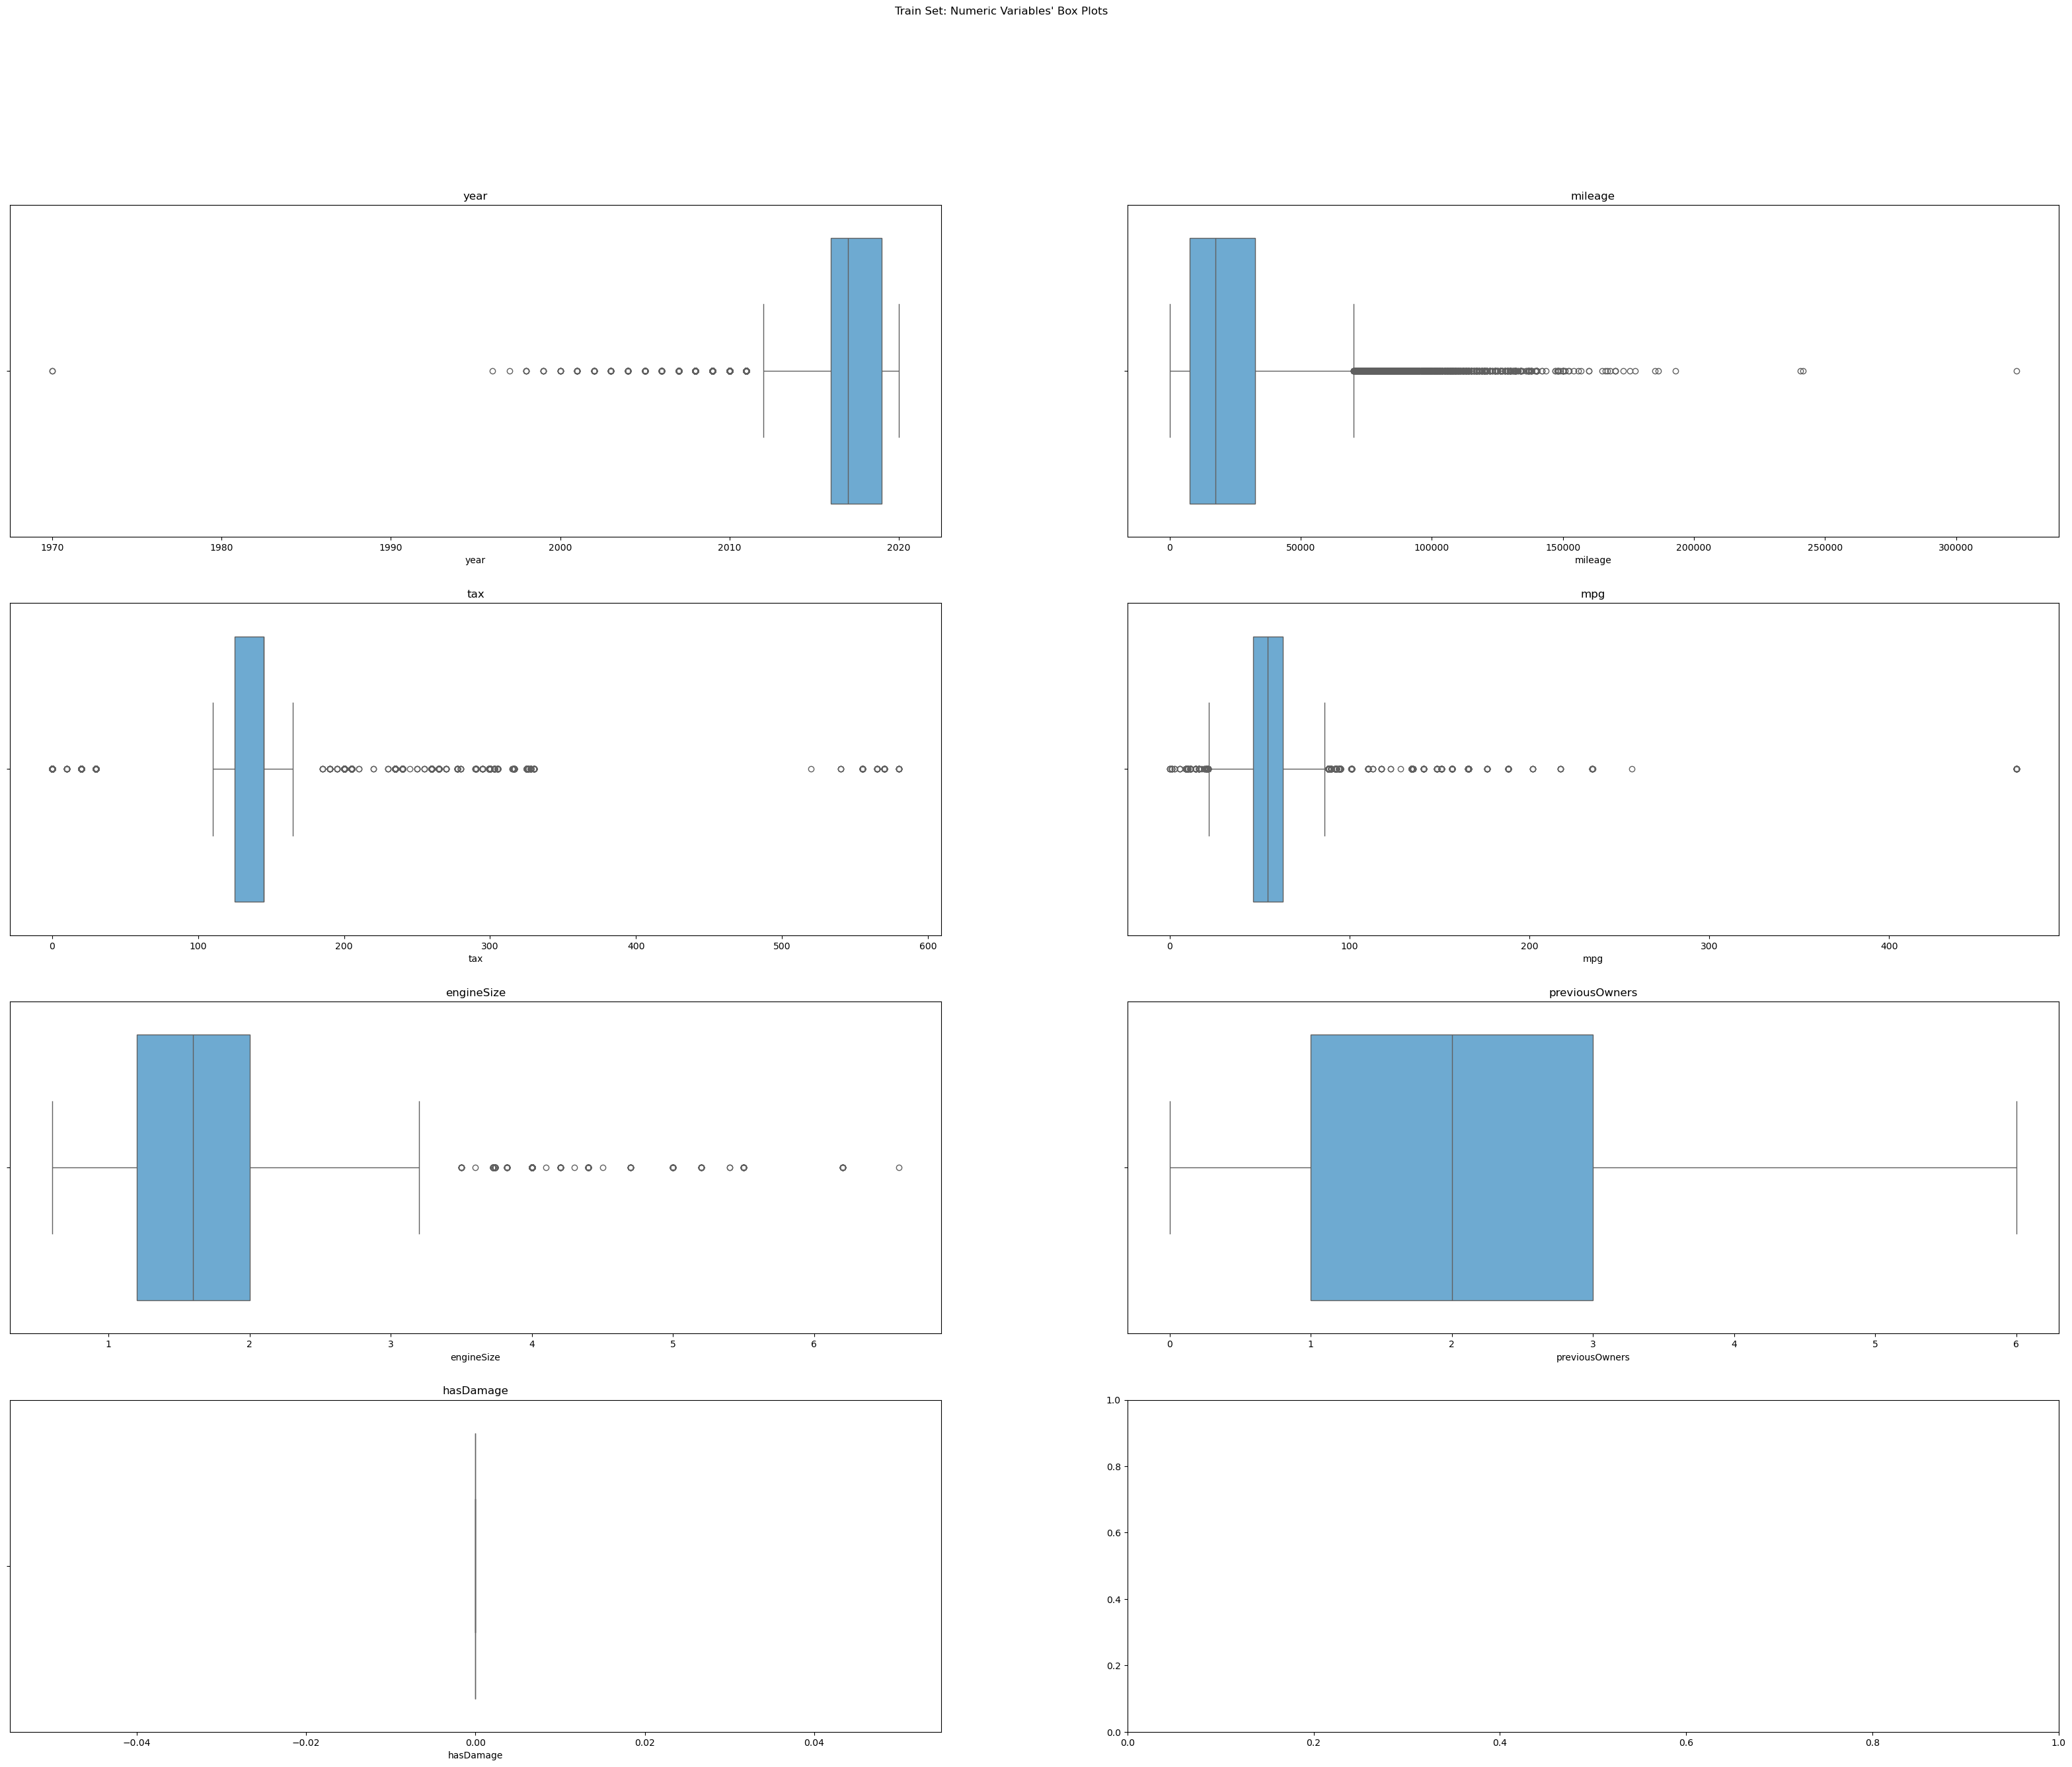

In [83]:
#checking outliers again after handling incoherencies on X_train
plot_multiple_boxplots(X_train, metric_features, title="Train Set: Numeric Variables' Box Plots")

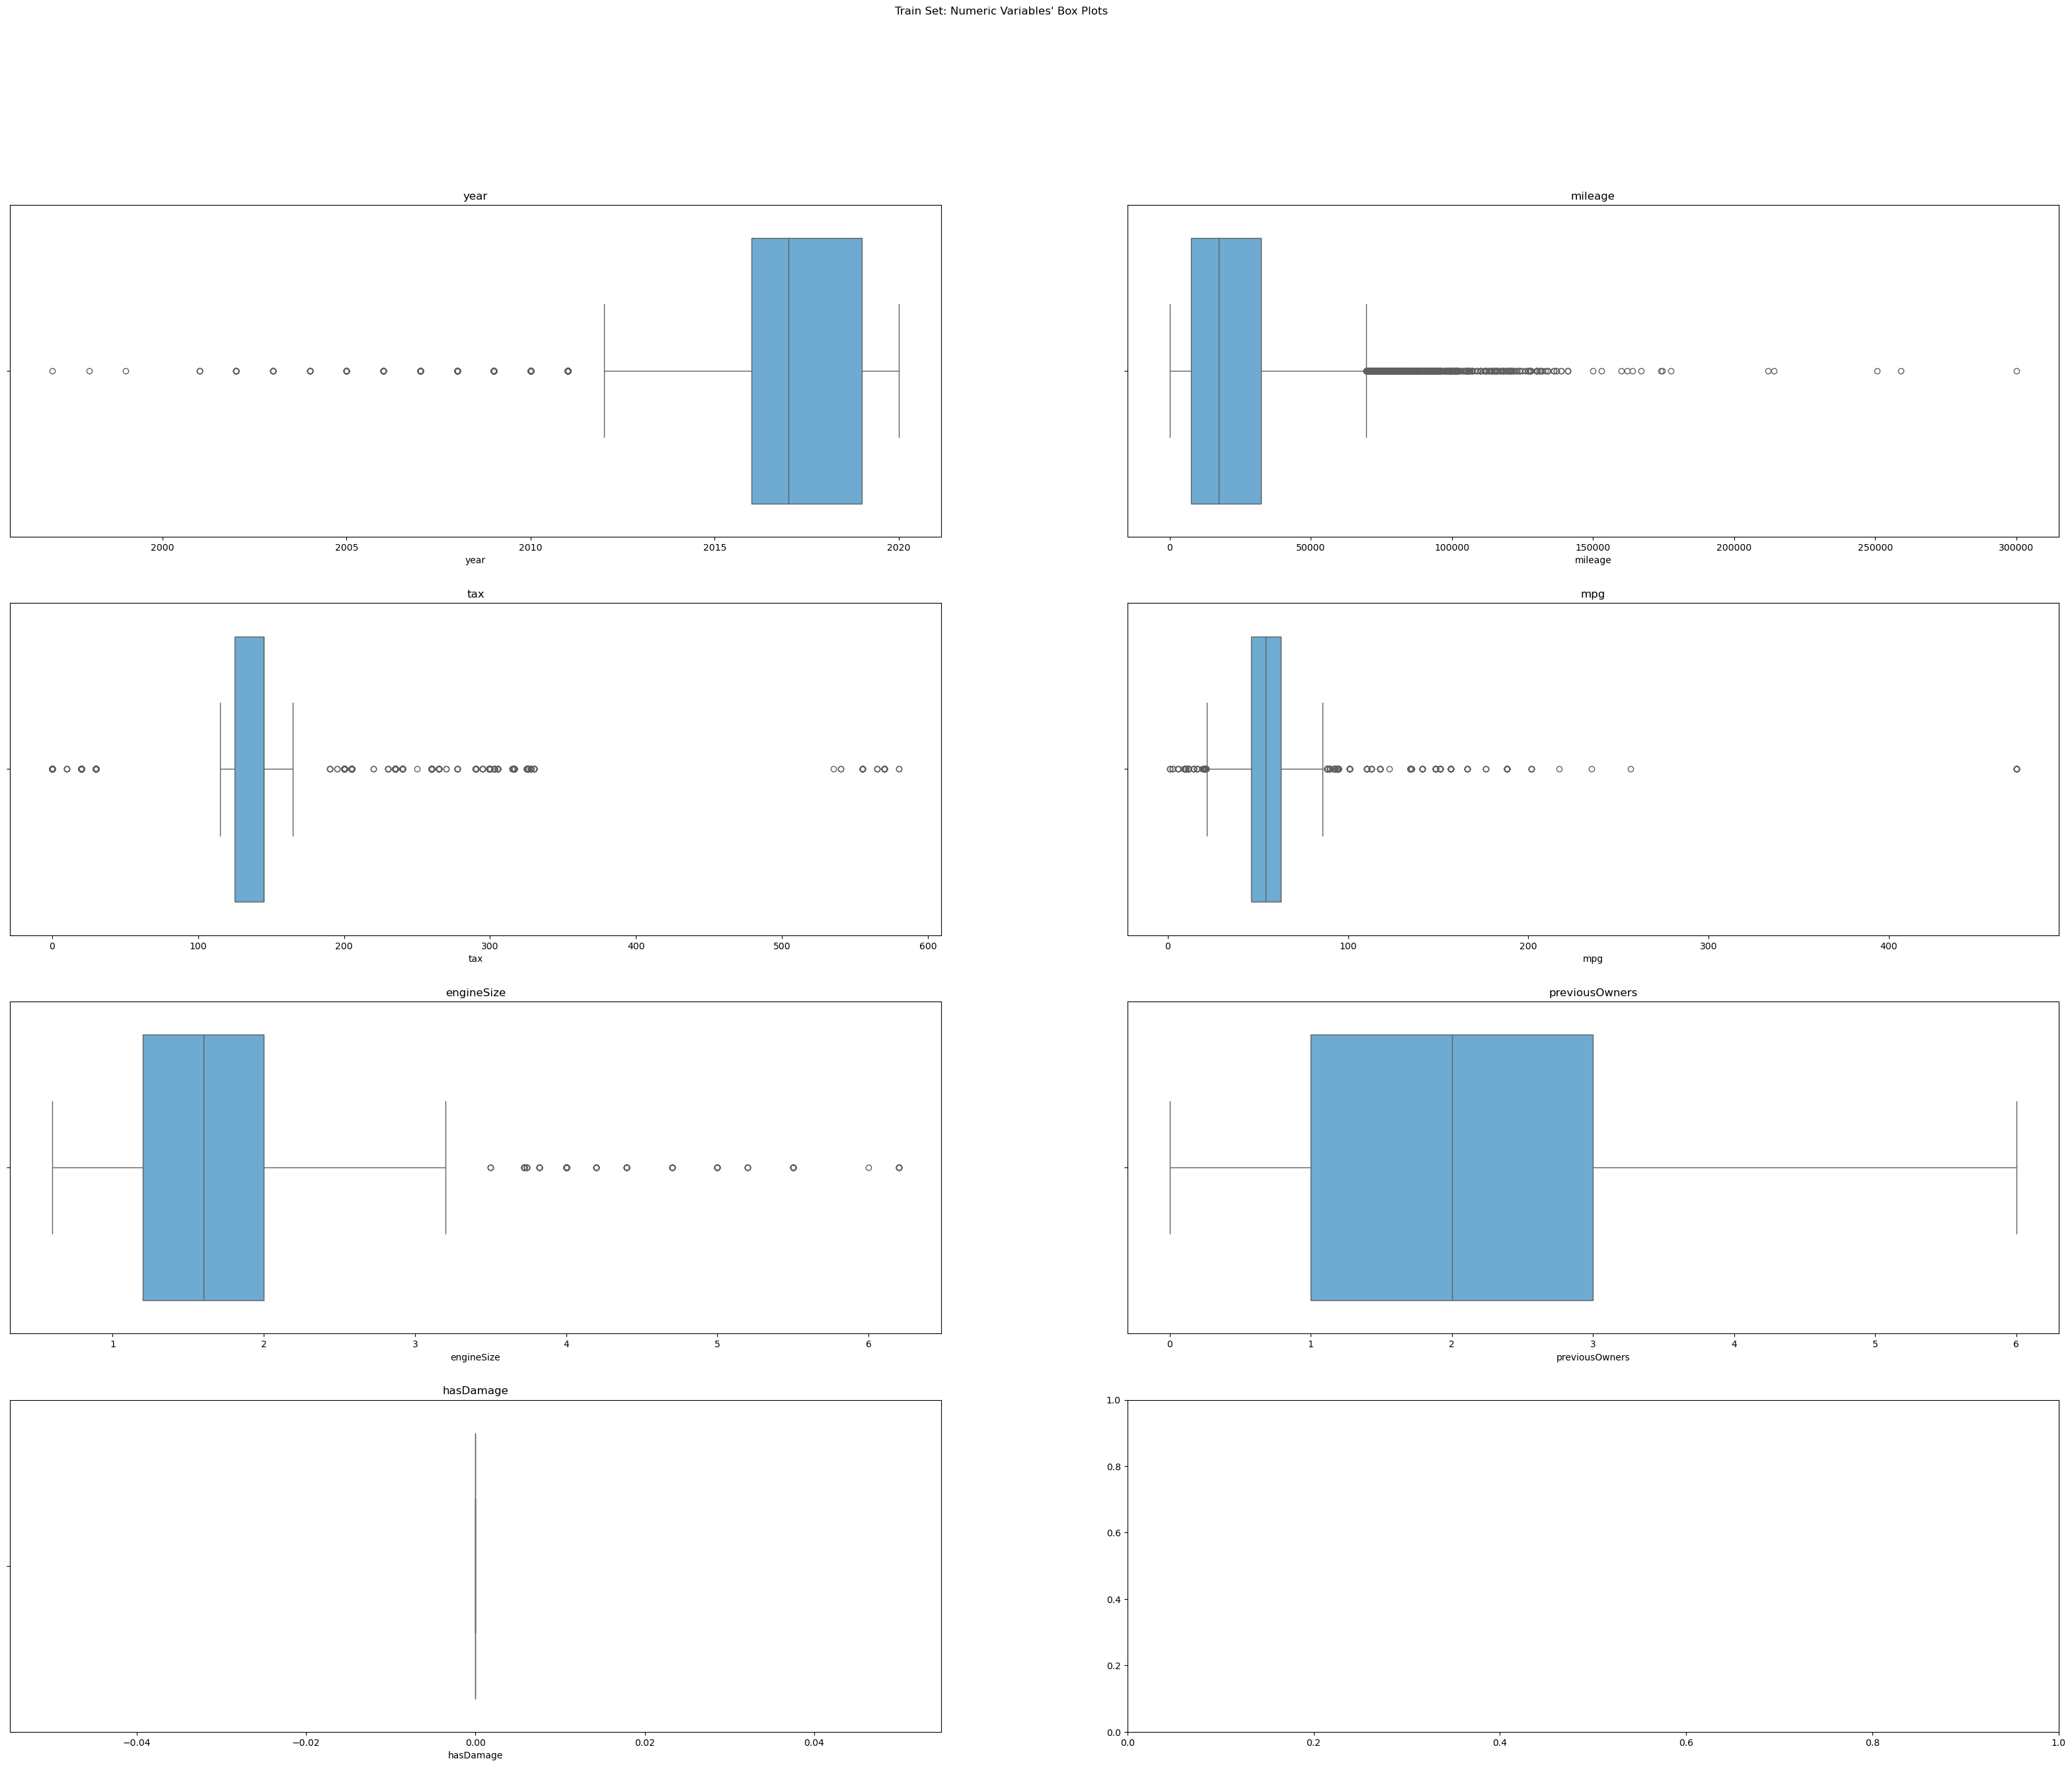

In [84]:
#checking outliers again after handling incoherencies on X_train
plot_multiple_boxplots(X_val, metric_features, title="Train Set: Numeric Variables' Box Plots")

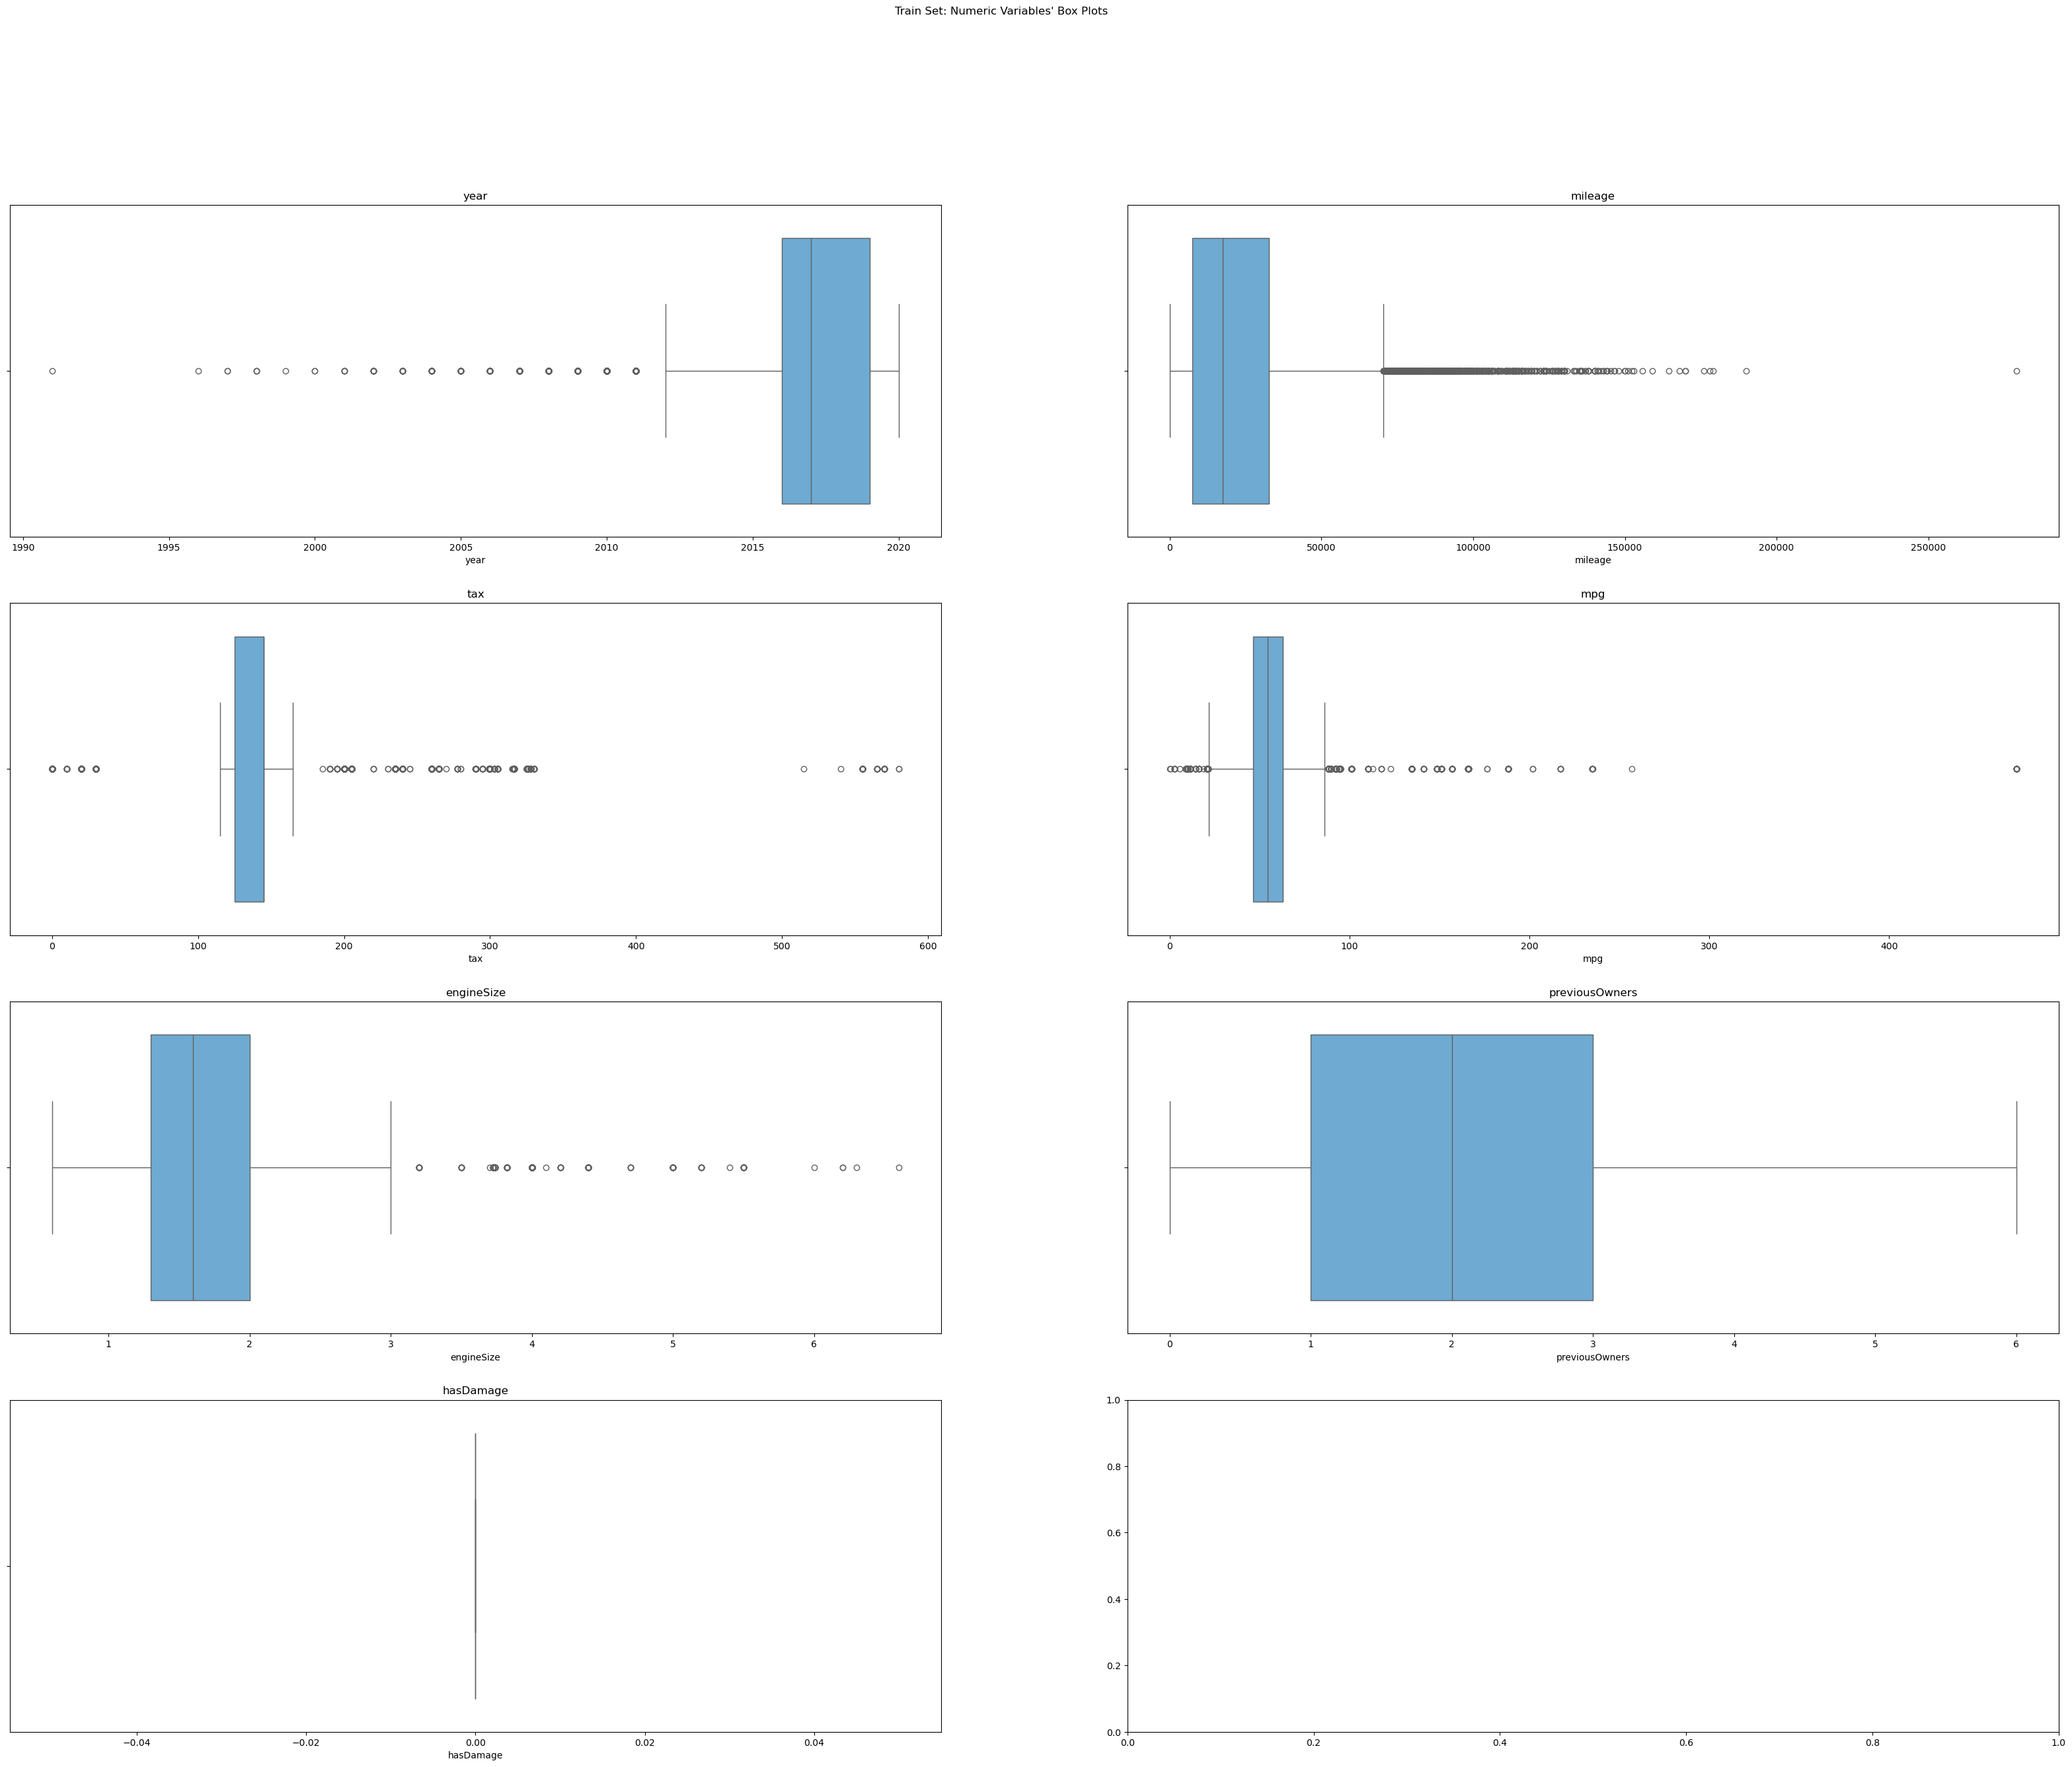

In [85]:
#checking outliers again after handling incoherencies on test_data
plot_multiple_boxplots(test_data, metric_features, title="Train Set: Numeric Variables' Box Plots")

**Year**

The variable *year* will have ranges between 1995 and 2020. 

In [86]:
X_train[X_train['year'] < 1995]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
62732,Opel,Zafira,1970,Manual,37357.0,NaN,200.0,42.2,NaN,2,0
35769,Mercedes,M Class,1970,Automatic,14000.0,Diesel,305.0,39.2,NaN,3,0


In [87]:
X_val[X_val['year'] < 1995]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,


In [88]:
test_data[test_data['year'] < 1995]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
94627,Mercedes,C Class,1991,Automatic,170000.0,Petrol,NaN,NaN,3.0,4,0


In [89]:
#replacing years before 1995 by missing values for X_train and test_data
X_train.loc[X_train["year"] < 1995, "year"] = np.nan
test_data.loc[test_data["year"] < 1995, "year"] = np.nan

**Milage**

The variable *Mileage* will have ranges between 0 and 150000. 

In [90]:
X_train[X_train['mileage'] > 150000]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
58385,Opel,Astra,2008,Manual,186500.0,Petrol,260.0,36.7,1.8,1,0
45553,Mercedes,C Class,2012,Automatic,170000.0,Diesel,145.0,54.3,2.1,4,0
7038,Audi,A3,2009,Manual,152034.0,Diesel,150.0,55.4,1.9,4,0
19562,Ford,Focus,2003,Manual,177644.0,Petrol,200.0,41.5,1.6,2,0
45795,Mercedes,C Class,2008,Automatic,170000.0,Diesel,NaN,NaN,2.1,3,0
67297,VW,Golf,2009,Manual,193000.0,Diesel,160.0,52.3,2.0,3,0
41580,Mercedes,C Class,2012,Automatic,170000.0,Diesel,NaN,NaN,2.1,2,0
4692,Audi,A6,2008,Manual,323000.0,Diesel,200.0,44.1,2.0,1,0
12289,BMW,3 Series,2010,Manual,156800.0,Diesel,125.0,58.9,2.0,4,0


In [91]:
X_val[X_val['mileage'] > 150000]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
48042,Skoda,Octavia,2010,Manual,250650.0,Diesel,125.0,57.6,1.9,1,0
74387,VW,Caravelle,2012,NaN,212000.0,Diesel,325.0,34.4,2.0,2,0
23427,Ford,Focus,2003,Manual,177644.0,Petrol,NaN,NaN,1.6,4,0
21764,Ford,Galaxy,2008,Manual,174000.0,Diesel,220.0,44.8,1.8,4,0
9978,BMW,X5,2012,Automatic,214000.0,Diesel,300.0,37.7,3.0,1,0
9808,BMW,3 Series,<NA>,Manual,162000.0,Diesel,205.0,49.6,2.0,0,0
45370,Mercedes,V Class,2010,Automatic,259000.0,Diesel,540.0,30.7,3.0,1,0
66971,VW,Golf,2010,Manual,164000.0,Diesel,145.0,58.9,2.0,2,0
46713,Mercedes,C Class,2007,Automatic,160000.0,Diesel,NaN,NaN,2.2,4,0


In [92]:
test_data[test_data['mileage'] > 150000]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
78147,Audi,Q5,2011,Manual,168017.0,Diesel,200.0,42.10000,2.0,0,0
91517,Mercedes,C Class,2006,Automatic,153000.0,Petrol,300.0,33.60000,1.8,3,0
102018,Opel,Astra,2001,Manual,159000.0,Petrol,235.0,40.40000,1.6,4,0
81844,BMW,5 Series,2010,Automatic,164500.0,Diesel,140.0,53.30000,2.0,3,0
94627,Mercedes,C Class,<NA>,Automatic,170000.0,Petrol,NaN,NaN,3.0,4,0
100290,Opel,Zafira,2013,Manual,279000.0,Diesel,150.0,55.40000,1.7,3,0
80858,BMW,5 Series,2013,Automatic,178987.0,Hybrid,190.0,40.40000,3.0,3,0
106256,VW,Caravelle,2006,Manual,178000.0,Diesel,325.0,34.40000,2.5,0,0
80355,BMW,3 Series,2011,Manual,190000.0,Diesel,20.0,68.90000,2.0,0,0


In [93]:
#replacing mileages higher than 150000 by missing values
X_train.loc[X_train["mileage"] > 150000, "mileage"] = np.nan
X_val.loc[X_val["mileage"] > 150000, "mileage"] = np.nan
test_data.loc[test_data["mileage"] > 150000, "mileage"] = np.nan

**Tax**

The variable *tax* will have ranges between 0 and 350. 

In [94]:
X_train[X_train['tax'] < 50]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
74356,VW,Golf,2016,Semi-Auto,19432.0,Diesel,30.0,62.80000,2.0,3,0
75498,VW,Polo,2016,Semi-Auto,8695.0,Petrol,20.0,60.10000,1.2,2,0
51358,Toyota,Yaris,2017,Automatic,32994.0,Petrol,30.0,55.00000,1.3,2,0
2043,Audi,A1,2016,Semi-Auto,33435.0,Petrol,30.0,70.60000,1.4,0,0
166,Audi,A5,2014,Manual,30884.0,Diesel,30.0,60.10000,2.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...
28583,Ford,B-MAX,2013,Manual,37058.0,NaN,30.0,27.70949,1.0,3,0
31202,Ford,Focus,2017,Manual,13000.0,Petrol,20.0,61.40000,1.0,4,0
2492,Audi,A4,2016,Automatic,28325.0,Diesel,0.0,72.40000,2.0,3,0


- Since the number of cars with *tax* less than 100 is large, these we will not be changed. 

In [95]:
#the same as 400
X_train[X_train['tax'] > 350]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
41531,Mercedes,SL CLASS,2016,Automatic,6200.0,Petrol,555.0,28.0,5.5,4,<NA>
44516,Mercedes,SL CLASS,2010,Automatic,79000.0,Petrol,555.0,29.1,3.5,4,0
54636,Toyota,Land Cruiser,2006,Automatic,113000.0,Diesel,555.0,31.4,3.0,0,0
37494,Mercedes,M Class,2010,Automatic,128000.0,Diesel,555.0,32.5,3.0,1,0
52900,Toyota,Land Cruiser,2014,Automatic,60000.0,Diesel,540.0,29.7,4.5,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2116,Audi,RS6,2014,Automatic,59894.0,Petrol,555.0,28.8,NaN,4,0
56446,Opel,Antara,2007,Automatic,99500.0,Diesel,565.0,32.8,2.0,3,0
35606,Mercedes,M Class,2009,Automatic,59000.0,Diesel,555.0,30.4,3.0,2,0


In [96]:
X_val[X_val['tax'] > 350]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
2522,Audi,Q7,2009,Automatic,136000.0,NaN,540.0,31.0,3.0,1,0
12995,BMW,M3,2013,Automatic,58125.0,Petrol,570.0,25.2,4.0,3,0
39852,Mercedes,S Class,2010,Automatic,38000.0,Petrol,570.0,19.5,6.2,4,0
921,Audi,RS6,2014,Automatic,58000.0,Petrol,555.0,28.8,4.0,2,0
41484,Mercedes,S Class,2016,Automatic,14000.0,Petrol,555.0,28.0,5.5,4,0
73570,VW,Touareg,2007,Automatic,122965.0,Diesel,580.0,26.9,3.0,1,0
45503,Mercedes,GL Class,2007,Automatic,104000.0,Diesel,570.0,28.8,3.0,2,0
39351,NaN,GLE Class,2015,Automatic,13212.0,Petrol,570.0,23.7,NaN,2,0
34980,Mercedes,S Class,2014,Automatic,26000.0,Petrol,555.0,28.0,5.5,1,0


In [97]:
test_data[test_data['tax'] > 350]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
95966,Mercedes,S Class,2011,Automatic,66000.000000,Petrol,570.0,24.6,3.2,0,0
94732,Mercedes,S Class,2015,Automatic,23156.000000,Petrol,555.0,28.0,5.5,2,0
80066,BMW,M6,2016,Semi-Auto,26642.000000,Petrol,555.0,28.5,NaN,1,0
79095,Audi,A8,2015,Automatic,30306.000000,Petrol,570.0,25.0,6.3,2,0
80790,BMW,M5,<NA>,Automatic,55241.000000,Petrol,555.0,28.5,4.4,3,0
79753,BMW,M5,2015,Semi-Auto,42932.000000,Petrol,555.0,28.5,4.4,1,0
78115,Audi,A8,2017,Automatic,16975.000000,Petrol,555.0,28.2,4.0,0,0
103312,Opel,Insignia,2012,Manual,48490.000000,Petrol,555.0,25.9,2.8,2,0
95550,Mercedes,SL CLASS,2016,Automatic,19425.000000,NaN,555.0,NaN,5.5,0,0


In [98]:
#replacing taxes higher than 350 by missing values
X_train.loc[X_train["tax"] > 350, "tax"] = np.nan
X_val.loc[X_val["tax"] > 350, "tax"] = np.nan
test_data.loc[test_data["tax"] > 350, "tax"] = np.nan

**Mpg**

The variable *mpg* will have ranges between 0 and 300. 

In [99]:
X_train[X_train['mpg'] > 300]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
11068,BMW,I3,2016,NaN,43695.0,Hybrid,0.0,470.8,NaN,1,0
14531,BMW,I3,2017,Automatic,36429.0,Hybrid,0.0,470.8,NaN,2,0
12332,BMW,I3,2015,Automatic,65800.0,Hybrid,0.0,470.8,NaN,3,0
9643,BMW,I3,2017,Automatic,20929.0,Hybrid,135.0,470.8,NaN,2,0
12640,BMW,I3,2017,Automatic,23956.0,NaN,135.0,470.8,0.6,1,0
12269,BMW,I3,2017,Automatic,26965.0,Hybrid,140.0,470.8,NaN,3,0
13378,BMW,I3,2015,Automatic,9886.0,Hybrid,0.0,470.8,NaN,0,0
11962,BMW,I3,2017,Automatic,21025.0,Hybrid,0.0,470.8,NaN,0,0
10327,BMW,I3,2014,Automatic,42479.0,Hybrid,0.0,470.8,NaN,2,0


In [100]:
X_val[X_val['mpg'] > 300]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
11589,BMW,I3,2016,Automatic,25269.0,NaN,0.0,470.8,0.6,0,0
8497,BMW,I3,2017,Automatic,24041.0,Hybrid,0.0,470.8,NaN,3,0
12090,BMW,I3,2016,Automatic,8421.0,Hybrid,0.0,470.8,NaN,4,0
10967,BMW,I3,2016,Automatic,41063.0,NaN,0.0,470.8,0.6,6,0
8993,BMW,I3,2016,Automatic,9990.0,NaN,0.0,470.8,NaN,0,0
10133,BMW,I3,2017,Automatic,NaN,NaN,0.0,470.8,0.6,4,0
9196,BMW,I3,2016,Automatic,19995.0,Hybrid,0.0,470.8,NaN,3,0
13075,BMW,I3,2015,Automatic,33931.0,Hybrid,0.0,470.8,NaN,4,0


In [101]:
test_data[test_data['mpg'] > 300]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
80758,BMW,I3,2016,Automatic,59945.0,Hybrid,0.0,470.8,NaN,3,0
80669,BMW,I3,2017,Automatic,28169.0,Hybrid,0.0,470.8,NaN,3,0
80184,BMW,I3,2017,Automatic,41949.0,Hybrid,140.0,470.8,NaN,4,0
81032,BMW,I3,2017,Automatic,33021.0,Hybrid,0.0,470.8,NaN,3,0
79921,BMW,I3,2017,Automatic,50867.0,NaN,135.0,470.8,0.600000,2,0
82073,BMW,I3,2015,Automatic,59000.0,NaN,0.0,470.8,0.600000,1,0
80882,BMW,I3,2017,Automatic,10900.0,Hybrid,140.0,470.8,NaN,2,0
80277,BMW,I3,2017,Automatic,26139.0,Hybrid,135.0,470.8,NaN,2,0
79191,BMW,I3,2017,Automatic,17338.0,Hybrid,135.0,470.8,NaN,0,0


- All mpg > 300 are from BMW I3 and they all have the same mpg.

In [102]:
#replacing mpg higher than 300 by missing values
X_train.loc[X_train["mpg"] > 300, "mpg"] = np.nan
X_val.loc[X_val["mpg"] > 300, "mpg"] = np.nan
test_data.loc[test_data["mpg"] > 300, "mpg"] = np.nan

**EngineSize**

The variable *engineSize* will have ranges between 0.5 and 5. 

In [103]:
X_train[X_train['engineSize'] > 5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
41531,Mercedes,SL CLASS,2016,Automatic,6200.0,Petrol,NaN,28.0,5.5,4,<NA>
35538,NaN,C Class,<NA>,Semi-Auto,49964.0,Petrol,326.028233,NaN,6.2,3,0
2487,Audi,R8,2019,Semi-Auto,7800.0,Petrol,145.000000,21.4,5.2,4,0
45626,Mercedes,SL CLASS,2016,Semi-Auto,21681.0,Petrol,NaN,28.0,5.5,1,0
37895,Mercedes,GLE Class,2019,Semi-Auto,11545.0,Petrol,145.000000,23.9,5.5,2,0
35290,Mercedes,C Class,2014,Automatic,56444.0,Petrol,NaN,23.5,6.2,0,0
39752,Mercedes,C Class,2014,Automatic,56444.0,Petrol,NaN,NaN,6.2,3,0
2022,Audi,R8,2019,Automatic,8175.0,Petrol,145.000000,21.6,5.2,4,0
40976,Mercedes,GLE Class,2019,Semi-Auto,9.0,Petrol,145.000000,23.7,5.5,1,0


In [104]:
X_val[X_val['engineSize'] > 5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
6647,Audi,R8,<NA>,Semi-Auto,4000.000000,Petrol,145.0,21.4,5.2,4,0
44293,Mercedes,S Class,1998,Automatic,43534.000000,Petrol,NaN,23.3,6.0,2,0
44376,Mercedes,SL CLASS,2019,Semi-Auto,3728.000000,Petrol,145.0,28.0,5.5,1,0
39852,Mercedes,S Class,2010,Automatic,38000.000000,Petrol,NaN,19.5,6.2,4,0
46372,Mercedes,C Class,2013,Semi-Auto,49964.000000,Petrol,NaN,23.0,6.2,3,0
41484,Mercedes,S Class,2016,Automatic,14000.000000,Petrol,NaN,28.0,5.5,4,0
46668,Mercedes,GLE Class,2017,Automatic,7000.000000,Petrol,145.0,29.5,5.5,3,0
34980,Mercedes,S Class,2014,Automatic,26000.000000,Petrol,NaN,28.0,5.5,1,0
36076,Mercedes,SL CLASS,2017,Semi-Auto,NaN,Petrol,145.0,28.0,5.5,0,0


In [105]:
test_data[test_data['engineSize'] > 5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
94732,Mercedes,S Class,2015,Automatic,23156.000000,Petrol,NaN,28.0,5.5,2,0
79095,Audi,A8,2015,Automatic,30306.000000,Petrol,NaN,25.0,6.3,2,0
95550,Mercedes,SL CLASS,2016,Automatic,19425.000000,NaN,NaN,NaN,5.5,0,0
92738,Mercedes,CLS Class,2012,Automatic,46283.000000,Petrol,NaN,28.5,5.5,3,0
91008,Mercedes,GL Class,2014,Automatic,55000.000000,Petrol,NaN,23.0,5.5,4,<NA>
76804,Audi,R8,2020,Semi-Auto,333.000000,Petrol,145.0,21.4,5.2,1,0
94754,Mercedes,C Class,2013,Automatic,41866.000000,Petrol,NaN,NaN,6.2,1,0
77563,Audi,R8,2019,Automatic,11936.000000,Petrol,145.0,21.4,5.2,0,0
95730,Mercedes,SL CLASS,2014,Semi-Auto,86705.854885,Petrol,NaN,28.5,5.5,3,0


In [106]:
#replacing mileages higher than 150000 by missing values
X_train.loc[X_train["engineSize"] > 5, "engineSize"] = np.nan
X_val.loc[X_val["engineSize"] > 5, "engineSize"] = np.nan
test_data.loc[test_data["engineSize"] > 5, "engineSize"] = np.nan

### 4.7. Treating Missing Values
Considering that most of techniques used to handle incoherencies and treating outliers in numerical features consisted on replacing the numbers by missing values, we needed a good technique that was able to fill the missing values according to our dataset. Through the analysis made in the previous steps, we understood that if we want to fill a missing value of a certain variable, we cannot solely consider existent values of the same variable, we have to consider the rest of the variables of the dataset as well. For example, if our objective is to fill the *engineSize* of a certain observation, we should take into account its model and brand, assuming that is likely for a *Ford focus* to have the same or similiar engine size as other *Ford focus* that may exist in our dataset. 
For this reason, we have decided to fill numerical and categorical features using **Interactive Imputer** with **Extra Trees** as an estimator, which fill each variable with missing values using all the other variables as predictors. Moreover, *ExtraTrees* is abble to learn the nonlinear relationships present in our data and it captures interaction between variables. 

#### 4.7.1. Interative Imputer
The first step to apply the interactive imputer was temporarily changing the categorical fetures to numerical using *Ordinal Encoding*. This action was required because the model that Iterative Imputer uses internally (in this case, *Extra Trees*) is a mathematical regression algorithm that can only operate on numeric features. We used *Ordinal Encoding* because missing values remain missing during the process and *Extra Trees* do not treat the encoded data as ordered values, it simply uses the numeric codes to split the data into groups. 

In [107]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.neural_network import MLPRegressor

In [108]:
#Define the columns
num_cols = ['mileage', 'mpg', 'tax', 'engineSize', 'previousOwners', 'year']
cat_cols = ['fuelType', 'transmission', 'hasDamage','Brand', 'model']
impute_features = num_cols + cat_cols

In [109]:
#TEMPORARY Ordinal Encoding (only for imputation of missing values)
#since interactive imputer does not require scalling we can use ordinal encoding
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()
test_data_enc = test_data.copy()

# Encode categorical variables temporarily
X_train_enc[cat_cols] = ordinal_encoder.fit_transform(X_train[cat_cols])
X_val_enc[cat_cols] = ordinal_encoder.transform(X_val[cat_cols])
test_data_enc[cat_cols] = ordinal_encoder.transform(test_data[cat_cols])

In [110]:
#checking if X_train and y_train have the same number of rows
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (52817, 11)
y_train shape: (53181,)


##### 4.7.1.1. Numerical Variables
For numerical variables, we have decided to use *Iterative Imputer* with an *ExtraTreesRegressor*. This is caracterized for being a non-linear, tree-based model that can learn complex patterns between variables such as brand, model, engine size, and mpg. Becaue of this, it can generate more realistic imputations than simpler methods like filling with the mean or the median. 
It is important to note that even tough only the numerical variables are being imputed in this code, it is taking into account the categorical features as well to fill these missing values. 

In [111]:
#Numerical imputation using ExtraTreesRegressor

num_imputer_ETR = ExtraTreesRegressor(
    n_estimators=80,                                      
    max_depth=12,
    min_samples_leaf=2,
    max_features=None,
    n_jobs=-1,
    random_state=42
)

num_imputer = IterativeImputer(
    estimator=num_imputer_ETR,
    max_iter=12,
    initial_strategy='median',
    imputation_order='ascending',
    skip_complete=True,
    random_state=42
)

# Fit on training (using all predictors) and transform train/val/test
train_num_imputed = num_imputer.fit_transform(X_train_enc[impute_features])
val_num_imputed   = num_imputer.transform(X_val_enc[impute_features])
test_num_imputed  = num_imputer.transform(test_data_enc[impute_features])

# Returned arrays have columns in the same order as impute_features.
# Replace numeric columns in the DataFrames with the imputed numeric values:
X_train_enc[num_cols] = train_num_imputed[:, :len(num_cols)]
X_val_enc[num_cols]   = val_num_imputed[:, :len(num_cols)]
test_data_enc[num_cols]  = test_num_imputed[:, :len(num_cols)]
#here only the numerical variables are being imputed but we are taking into account the categorical features as well to fill them 

# Quick check:
print("Missing in numeric (train) after numeric imputation:\n", X_train_enc[num_cols].isna().sum())
print("Missing in numeric (val)   after numeric imputation:\n", X_val_enc[num_cols].isna().sum())
print("Missing in numeric (test)  after numeric imputation:\n", test_data_enc[num_cols].isna().sum())

C:\Users\martr\OneDrive\Documentos\ANACONDA\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Missing in numeric (train) after numeric imputation:
 mileage           0
mpg               0
tax               0
engineSize        0
previousOwners    0
year              0
dtype: int64
Missing in numeric (val)   after numeric imputation:
 mileage           0
mpg               0
tax               0
engineSize        0
previousOwners    0
year              0
dtype: int64
Missing in numeric (test)  after numeric imputation:
 mileage           0
mpg               0
tax               0
engineSize        0
previousOwners    0
year              0
dtype: int64


##### 4.7.1.2. Categorical Variables
For categorical variables, we have decided to apply another *Iterative Imputer*, but this time using an *ExtraTreesClassifier*. This technique allows the missing categories to be predicted using all available information from the car’s characteristics, leading to more consistent and accurate imputations. 
Similarly to numerical imputation, this code is also taking into account the numerical variables to fill the missing values of categorical features. 


In [112]:
#Categorical imputation using ExtraTreesClassifier

cat_imputer_ETC = ExtraTreesClassifier(
    n_estimators=80,
    max_depth=12,
    min_samples_leaf=2,
    max_features=None,
    n_jobs=-1, 
    random_state=42
)

cat_imputer = IterativeImputer(
    estimator=cat_imputer_ETC,
    max_iter=12,
    initial_strategy='most_frequent',
    imputation_order='ascending',
    skip_complete=True,
    random_state=42)

# Fit and transform categorical columns
X_train_imputed = cat_imputer.fit_transform(X_train_enc[impute_features])
X_val_imputed = cat_imputer.transform(X_val_enc[impute_features])
test_data_imputed = cat_imputer.transform(test_data_enc[impute_features])

# Convert the returned arrays to DataFrame with columns = impute_features so we can select by name
train_cat_df = pd.DataFrame(X_train_imputed, columns=impute_features, index=X_train_enc.index)
val_cat_df   = pd.DataFrame(X_val_imputed,   columns=impute_features, index=X_val_enc.index)
test_cat_df  = pd.DataFrame(test_data_imputed,  columns=impute_features, index=test_data_enc.index)

# Extract only the categorical columns (they remain in the same columns by name)
# Round and cast to int because classifier outputs were returned as floats by the imputer
train_cat_codes = train_cat_df[cat_cols].round().astype(int)
val_cat_codes   = val_cat_df[cat_cols].round().astype(int)
test_cat_codes  = test_cat_df[cat_cols].round().astype(int)

# Assign the imputed category codes back into the working DataFrames
X_train_enc[cat_cols] = train_cat_codes
X_val_enc[cat_cols]   = val_cat_codes
test_data_enc[cat_cols]  = test_cat_codes

In [113]:
print("Total missing values in training dataset after imputations:")
print(X_train_enc.isna().sum().sort_values(ascending=False))
print("Total missing values in validation dataset after imputations:")
print(X_val_enc.isna().sum().sort_values(ascending=False))
print("Total missing values in test dataset after imputations:")
print(test_data_enc.isna().sum().sort_values(ascending=False))

Total missing values in training dataset after imputations:
Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64
Total missing values in validation dataset after imputations:
Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64
Total missing values in test dataset after imputations:
Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64


- After the imputation of missing values, the encoded categorical variables were converted back to their original labels.

In [114]:
# Map back to original categories
X_train_enc[cat_cols] = ordinal_encoder.inverse_transform(X_train_enc[cat_cols])
X_val_enc[cat_cols] = ordinal_encoder.inverse_transform(X_val_enc[cat_cols])
test_data_enc[cat_cols] = ordinal_encoder.inverse_transform(test_data_enc[cat_cols])

- Since we fit the train dataset and transform the validation and test dataset, there is the possibility of the validation and test dataset still have missing values after the interactive imputer because there are categories in *model* that never appeared in the training set so the imputer cannot impute them and leaves them as missing.
- Therefore, we have decided to fill these missing values with the mode of *X_train*. We have considered this option because the quantity of missing values left to fill is reduced (4 for validation and 16 for test).

In [115]:
print("Total missing values in training dataset after imputations:")
print(X_train_enc.isna().sum().sort_values(ascending=False))
print("Total missing values in validation dataset after imputations:")
print(X_val_enc.isna().sum().sort_values(ascending=False))
print("Total missing values in test dataset after imputations:")
print(test_data_enc.isna().sum().sort_values(ascending=False))

Total missing values in training dataset after imputations:
Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64
Total missing values in validation dataset after imputations:
model             4
Brand             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64
Total missing values in test dataset after imputations:
model             16
Brand              0
year               0
transmission       0
mileage            0
fuelType           0
tax                0
mpg                0
engineSize         0
previousOwners     0
hasDamage          0
dtype: int64


In [116]:
# ---------- 6) FINAL FALLBACK: fill any remaining NaNs in VAL/TEST using TRAIN stats (no leakage) ----------
# For each column that still has NaNs in val/test, fill with training median (numeric) or training mode (categorical)
for col in X_train_enc.columns:
    # validation
    if X_val_enc[col].isna().sum() > 0:
        if col in num_cols:
            fillval = X_train_enc[col].median()
        else:
            fillval = X_train_enc[col].mode()[0]
        X_val_enc[col] = X_val_enc[col].fillna(fillval)
    # test
    if test_data_enc[col].isna().sum() > 0:
        if col in num_cols:
            fillval = X_train_enc[col].median()
        else:
            fillval = X_train_enc[col].mode()[0]
        test_data_enc[col] = test_data_enc[col].fillna(fillval)

In [117]:
print("Total missing values in training dataset after imputations:")
print(X_train_enc.isna().sum().sort_values(ascending=False))
print("Total missing values in validation dataset after imputations:")
print(X_val_enc.isna().sum().sort_values(ascending=False))
print("Total missing values in test dataset after imputations:")
print(test_data_enc.isna().sum().sort_values(ascending=False))

Total missing values in training dataset after imputations:
Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64
Total missing values in validation dataset after imputations:
Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64
Total missing values in test dataset after imputations:
Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64


In [118]:
X_train = X_train_enc
X_val = X_val_enc
test_data = test_data_enc

**Links:**
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html
- https://chatgpt.com/share/692cad70-3fdc-8007-a212-ca8d1e5c714a

### 4.8. Feature Engineering
In feature engineering, we have decided to create a new variable called *engineEfficiency* and encode the categorical variables using frequency encoding for *brand* and *model* and *One Hot Encoder* for *transmission* and *fuelType*.  

#### 4.8.1. Creating New Variables
*engineEfficiency* is the division of *mpg* by *engineSize* and it was created to represent the average miles per gallon achieved per liter of engine size in the car. If the *engineEfficiency* has higher values, it indicates greater fuel efficiency relative to engine size, whereas lower values indicates less efficient utilization of engine displacement. 

In [119]:
X_train['engineEfficiency'] = X_train['mpg'] / X_train['engineSize']
X_val['engineEfficiency'] = X_val['mpg'] / X_val['engineSize']
test_data['engineEfficiency'] = test_data['mpg'] / test_data['engineSize']

#### 4.8.2. Encoding Categorical Features
- Since *brand* and *model* have a high cardinality, we have decided to use frequency encoding to transform them into numerical features to be able to correctly train models. In this way, each model and brand are replaced by the frequency they appear in the dataset. 
- On the other hand, *transmission* and *fuelType* were encoded using *OneHotEncoder*, since the number of categories is not too high. This created a new binary column for each unique category and each row assumes 1 in the column corresponding to its category, and 0 in all others.

In [120]:
freq_encoding_brand = X_train['Brand'].value_counts()
X_train['brand_encoded'] = X_train['Brand'].map(freq_encoding_brand)
X_val['brand_encoded'] = X_val['Brand'].map(freq_encoding_brand)
test_data['brand_encoded'] = test_data['Brand'].map(freq_encoding_brand)

In [121]:
freq_encoding_model = X_train['model'].value_counts()
X_train['model_encoded'] = X_train['model'].map(freq_encoding_model)
X_val['model_encoded'] = X_val['model'].map(freq_encoding_model)
test_data['model_encoded'] = test_data['model'].map(freq_encoding_model)

In [122]:
print(X_train["fuelType"].value_counts())
print(X_val["fuelType"].value_counts())
print(test_data["fuelType"].value_counts())

fuelType
Petrol      29192
Diesel      22020
Hybrid       1601
Electric        4
Name: count, dtype: int64
fuelType
Petrol    12541
Diesel     9456
Hybrid      708
Name: count, dtype: int64
fuelType
Petrol      17883
Diesel      13702
Hybrid        981
Electric        1
Name: count, dtype: int64


- We observed that *fuelType* contained only 4 Electric cars, which is an extremely low representation for a category, and 46 rows defined as "other". To prevent overfitting and unstable coefficients, these categories were grouped together into the *Other* class.

In [123]:
rare_fuels = ['Electric', 'Other']
X_train['fuelType'] = X_train['fuelType'].replace(rare_fuels, 'Other')
X_val['fuelType'] = X_val['fuelType'].replace(rare_fuels, 'Other')
test_data['fuelType'] = test_data['fuelType'].replace(rare_fuels, 'Other')

In [124]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ['fuelType', 'transmission']
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', encoder, categorical_features)
    ],
    remainder='passthrough',
)
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
test_data_processed = preprocessor.transform(test_data)

In [125]:
new_ohe_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features) 
passthrough_cols = [col for col in X_train.columns if col not in categorical_features]

new_column_names = np.concatenate([new_ohe_feature_names, passthrough_cols])

X_train_encoded = pd.DataFrame(X_train_processed, columns=new_column_names, index=X_train.index)
X_val_encoded = pd.DataFrame(X_val_processed, columns=new_column_names, index=X_val.index)
test_data_encoded = pd.DataFrame(test_data_processed, columns=new_column_names, index=test_data.index)

- Since *One Hot Encoder* transformed all variables' datatypes into floats, we replaced them for the correct ones in each variable.

In [126]:
int_columns = [
    'brand_encoded',
    'model_encoded',
    'transmission_Manual',
    'transmission_Semi-Auto',
    'fuelType_Hybrid',
    'fuelType_Other',
    'fuelType_Petrol'
]

# Columns that should remain floats
float_columns = [
    'year',
    'mileage',
    'tax',
    'mpg',
    'engineSize',
    'previousOwners',
    'hasDamage',
    'engineEfficiency'
]

# ============================
# 2. SAFELY FIX INTEGER COLUMNS
# ============================

for col in int_columns:
    # TRAIN
    if col in X_train_encoded.columns:
        X_train_encoded[col] = pd.to_numeric(
            X_train_encoded[col], errors='coerce'
        )
        X_train_encoded[col] = X_train_encoded[col].round().astype('Int32')

    # VALIDATION
    if col in X_val_encoded.columns:
        X_val_encoded[col] = pd.to_numeric(
            X_val_encoded[col], errors='coerce'
        )
        X_val_encoded[col] = X_val_encoded[col].round().astype('Int32')
    # TEST
    if col in test_data_encoded.columns:
        test_data_encoded[col] = pd.to_numeric(
            test_data_encoded[col], errors='coerce'
        )
        test_data_encoded[col] = test_data_encoded[col].round().astype('Int32')
# ============================
# 3. FORCE FLOAT COLUMNS
# ============================

for col in float_columns:
    # TRAIN
    if col in X_train_encoded.columns:
        X_train_encoded[col] = pd.to_numeric(
            X_train_encoded[col], errors='coerce'
        ).astype('float64')
    # VALIDATION
    if col in X_val_encoded.columns:
        X_val_encoded[col] = pd.to_numeric(
            X_val_encoded[col], errors='coerce'
        ).astype('float64')

    # TEST
    if col in test_data_encoded.columns:
        test_data_encoded[col] = pd.to_numeric(
            test_data_encoded[col], errors='coerce'
        ).astype('float64')
# ============================
# 4. FINAL DATA TYPE CHECK
# ============================

print("\n--- X_train_encoded Data Types ---")
print(X_train_encoded.dtypes)

print("\n--- X_val_encoded Data Types ---")
print(X_val_encoded.dtypes)

print("\n--- test_data Data Types ---")
print(test_data_encoded.dtypes)


--- X_train_encoded Data Types ---
fuelType_Hybrid             Int32
fuelType_Other              Int32
fuelType_Petrol             Int32
transmission_Manual         Int32
transmission_Semi-Auto      Int32
Brand                      object
model                      object
year                      float64
mileage                   float64
tax                       float64
mpg                       float64
engineSize                float64
previousOwners            float64
hasDamage                 float64
engineEfficiency          float64
brand_encoded               Int32
model_encoded               Int32
dtype: object

--- X_val_encoded Data Types ---
fuelType_Hybrid             Int32
fuelType_Other              Int32
fuelType_Petrol             Int32
transmission_Manual         Int32
transmission_Semi-Auto      Int32
Brand                      object
model                      object
year                      float64
mileage                   float64
tax                       float6

In [127]:
X_train= X_train_encoded
X_val = X_val_encoded
test_data = test_data_encoded

In [128]:
X_val.isna().sum().sort_values(ascending=False)

fuelType_Hybrid           0
fuelType_Other            0
fuelType_Petrol           0
transmission_Manual       0
transmission_Semi-Auto    0
Brand                     0
model                     0
year                      0
mileage                   0
tax                       0
mpg                       0
engineSize                0
previousOwners            0
hasDamage                 0
engineEfficiency          0
brand_encoded             0
model_encoded             0
dtype: int64

In [129]:
test_data.isna().sum().sort_values(ascending=False)

fuelType_Hybrid           0
fuelType_Other            0
fuelType_Petrol           0
transmission_Manual       0
transmission_Semi-Auto    0
Brand                     0
model                     0
year                      0
mileage                   0
tax                       0
mpg                       0
engineSize                0
previousOwners            0
hasDamage                 0
engineEfficiency          0
brand_encoded             0
model_encoded             0
dtype: int64

In [130]:
X_train = X_train.drop(['Brand', 'model'], axis=1)
X_val = X_val.drop(['Brand', 'model'], axis=1)
test_data = test_data.drop(['Brand', 'model'], axis=1)

In [131]:
# ensuring that y_train has the same rows X_train
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (52817, 15)
y_train shape: (52817,)


In [132]:
X_val.head()

,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,transmission_Manual,transmission_Semi-Auto,year,mileage,tax,mpg,engineSize,previousOwners,hasDamage,engineEfficiency,brand_encoded,model_encoded
carID,,,,,,,,,,,,,,,
37025,0,0,0,0,1,2016.0,30863.917547,30.0,64.200000,1.6,0.0,0.0,40.125000,8252,3774
65090,0,0,1,1,0,2015.0,61000.000000,160.0,45.251565,1.4,1.0,0.0,32.322547,6598,422
29197,0,0,1,1,0,2018.0,8839.000000,145.0,57.700000,1.0,0.0,0.0,57.700000,11331,4852
22100,0,0,1,1,0,2019.0,6220.000000,145.0,58.900000,1.0,6.0,0.0,58.900000,11331,4852
70417,0,0,1,1,0,2019.0,6209.000000,145.0,47.900000,1.0,3.0,0.0,47.900000,7385,152


### 4.9. Scaling
Since several models and feature selection techniques need the data to be in the same range in order to function correctly (example: models that use distances), we have scaled all the features of the dataset using *MinMaxScaler*. This scaler has been chosen beacuse it scales all values to a consistent range [0, 1], it does not center or change the shape of the original distribution and it makes easier to compare feature importance or visualize relationships between variables.

In [133]:
#scale the variables using MinMaxScaler()
var = ['tax', 'mpg', 'mileage', 'engineSize', 'hasDamage', 'previousOwners', 'year', 'engineEfficiency', 'brand_encoded',  'model_encoded' ]
scaler = MinMaxScaler()

# fitting the scaler only on training dataset (to avoid leakage)
X_train[var] = scaler.fit_transform(X_train[var])

# transforming validation and test dataset using the same scaling
X_val[var] = scaler.transform(X_val[var])
test_data[var] = scaler.transform(test_data[var])

In [134]:
#checking if X_train and y_train have the same number of rows
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (52817, 15)
y_train shape: (52817,)


In [135]:
#checking if X_val and y_val have the same number of rows
print("X_val shape:", X_train.shape)
print("y_val shape:", y_train.shape)

X_val shape: (52817, 15)
y_val shape: (52817,)


In [136]:
X_train.head()

,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,transmission_Manual,transmission_Semi-Auto,year,mileage,tax,mpg,engineSize,previousOwners,hasDamage,engineEfficiency,brand_encoded,model_encoded
carID,,,,,,,,,,,,,,,
42520,0,0,0,0,1,0.916667,0.008700,0.439394,0.161604,0.545455,0.500000,0.0,0.082555,0.654433,0.188621
25115,0,0,1,0,0,0.791667,0.052007,0.486962,0.176662,0.227273,0.333333,0.0,0.169214,1.000000,1.000000
45113,0,0,0,0,0,0.875000,0.123294,0.370469,0.233521,0.340909,0.666667,0.0,0.170420,0.654433,0.777778
34623,0,0,1,1,0,0.916667,0.044554,0.454545,0.196262,0.181818,0.500000,0.0,0.214843,0.000000,0.020202
66409,0,0,1,0,0,0.958333,0.084107,0.439394,0.146807,0.318182,0.500000,0.0,0.112494,0.557127,0.489384


In [137]:
test_data.head()

,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,transmission_Manual,transmission_Semi-Auto,year,mileage,tax,mpg,engineSize,previousOwners,hasDamage,engineEfficiency,brand_encoded,model_encoded
carID,,,,,,,,,,,,,,,
89856,0,0,1,0,0,0.804739,0.204661,0.621212,0.161604,0.227273,0.500000,0.0,0.154791,0.000000,0.051536
106581,0,0,1,0,1,0.875000,0.144857,0.454545,0.148754,0.318182,0.333333,0.0,0.113986,0.557127,0.184292
80886,0,0,1,0,0,0.833333,0.245275,0.378788,0.200156,0.204545,0.333333,0.0,0.204498,0.314254,0.117502
100174,0,0,1,1,0,0.958333,0.036880,0.439394,0.171729,0.136364,0.166667,0.0,0.219318,0.468799,0.057308
81376,0,0,0,0,1,0.958333,0.060380,0.454545,0.200156,0.318182,0.666667,0.0,0.153374,0.314254,0.202020


In [138]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32567 entries, 89856 to 99627
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fuelType_Hybrid         32567 non-null  Int32  
 1   fuelType_Other          32567 non-null  Int32  
 2   fuelType_Petrol         32567 non-null  Int32  
 3   transmission_Manual     32567 non-null  Int32  
 4   transmission_Semi-Auto  32567 non-null  Int32  
 5   year                    32567 non-null  float64
 6   mileage                 32567 non-null  float64
 7   tax                     32567 non-null  float64
 8   mpg                     32567 non-null  float64
 9   engineSize              32567 non-null  float64
 10  previousOwners          32567 non-null  float64
 11  hasDamage               32567 non-null  float64
 12  engineEfficiency        32567 non-null  float64
 13  brand_encoded           32567 non-null  float64
 14  model_encoded           32567 non-null 

### 4.10. Feature Selection

In order to correctly predict the price of the cars in our test dataset, it is important to chose a group of features that would be sufficient relevant to train the model. The choice of what features to keep was taken based on the analysis of filter, wrapper and embedded methods. The filter methods developed were the *Variance*, the *Spearman Correlation Matrix* and the *Mutual Information (MI)*, while in terms of wrapper methods, the *RFECV* and the *Sequential Feature Selector* with *Forward Selection* were the two methods chosen. In addition, *Lasso* and *Random Forest Feature Importance* were also taken into consideration as part of embedded methods. 
We have decided to analyse and retrieving insights of each method individually and, at the end, grouping all information in one table, it is could be easier to understan what features should be kept. 
In feature selection, we are only going to consider *X_train* and *X_val*.

#### 4.10.1. Filter Methods 
This methods are caracterized by being statistical approaches that do not consider any machine learning algorithm. Our objective is to compare our features against the target variable (*price*). However, these methods solely are not enough to conduct a good feature selection due to the fact that we are only looking to correlations between two variables at a time. There are cases where a variable can be "jointly significant". 

##### 4.10.1.1. Variance 
First, we looked at the variance of each variable to understand if there are variables whose variance is null or almost null. If a variable is null, it means it is irrelavant for training the model because all their observations are equal or similiar, not adding any new information. 

In [139]:
X_train.var()

fuelType_Hybrid           0.029394
fuelType_Other            0.000076
fuelType_Petrol           0.247227
transmission_Manual       0.245262
transmission_Semi-Auto    0.177247
year                       0.00805
mileage                   0.020213
tax                       0.034386
mpg                       0.003017
engineSize                0.015417
previousOwners            0.056251
hasDamage                      0.0
engineEfficiency          0.008239
brand_encoded             0.096097
model_encoded             0.095196
dtype: Float64

In [140]:
X_val.var()

fuelType_Hybrid           0.030212
fuelType_Other                 0.0
fuelType_Petrol           0.247271
transmission_Manual       0.246222
transmission_Semi-Auto    0.176747
year                      0.007849
mileage                   0.019689
tax                       0.034134
mpg                       0.003018
engineSize                0.015596
previousOwners            0.056102
hasDamage                      0.0
engineEfficiency          0.008359
brand_encoded             0.096037
model_encoded             0.096853
dtype: Float64

As previously seen, *hasDamaged* has a variance of 0, which is an indicator that would not be kept in the model. Also, the variable *fuelType_Other* presents a variance almost null in *X_train* (0.000076) and null in *X_val*, indicating that the majority of observations are equal. Therefore, according to this method, all variables should be kept except for **hasDamaged** and **fuelType_Other**

##### 4.10.1.2. Spearman correlation
The *Spearman Correlation Matrix* was developed in order to understand the monotonic relationship between features. We have decided to chose this method because unlike *Pearson Correlation*, *Spearman* is non-parametric, which means that it makes no assumptions about data's distribution. 

In [141]:
# Combine X_train and y_train into one dataframe
df_train = X_train.copy()
df_train['price'] = y_train.values  # ensure alignment

# Compute Spearman correlation
cor_spearman = df_train.corr(method='spearman')
cor_spearma

,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,transmission_Manual,transmission_Semi-Auto,year,mileage,tax,mpg,engineSize,previousOwners,hasDamage,engineEfficiency,brand_encoded,model_encoded
fuelType_Hybrid,1.000000,-0.001539,-0.196535,-0.199302,-0.046864,-0.011212,0.018932,-0.194196,0.229206,0.064171,-0.005618,NaN,0.114005,-0.177589,-0.105896
fuelType_Other,-0.001539,1.000000,-0.009674,-0.009997,-0.004760,-0.009988,0.003016,-0.014828,-0.015077,0.006034,0.003010,NaN,-0.015073,0.001792,-0.012442
fuelType_Petrol,-0.196535,-0.009674,1.000000,0.291457,-0.141003,0.106150,-0.202677,0.168472,-0.376689,-0.638581,0.001435,NaN,0.262579,0.017014,0.160787
transmission_Manual,-0.199302,-0.009997,0.291457,1.000000,-0.628272,-0.169410,0.145104,-0.175888,0.207956,-0.535069,0.006068,NaN,0.484908,0.101286,0.163055
transmission_Semi-Auto,-0.046864,-0.004760,-0.141003,-0.628272,1.000000,0.186738,-0.162984,0.144960,-0.179692,0.345857,-0.005168,NaN,-0.343305,-0.032176,-0.074226
year,-0.011212,-0.009988,0.106150,-0.169410,0.186738,1.000000,-0.800724,0.344169,-0.309709,-0.033726,-0.000378,NaN,-0.136807,-0.012014,-0.025974
mileage,0.018932,0.003016,-0.202677,0.145104,-0.162984,-0.800724,1.000000,-0.291422,0.328351,0.098350,0.006545,NaN,0.099888,0.012558,0.029408
tax,-0.194196,-0.014828,0.168472,-0.175888,0.144960,0.344169,-0.291422,1.000000,-0.573683,0.154951,0.002513,NaN,-0.427237,0.005367,-0.105710
mpg,0.229206,-0.015077,-0.376689,0.207956,-0.179692,-0.309709,0.328351,-0.573683,1.000000,-0.193284,0.002079,NaN,0.687173,0.076431,0.236295
engineSize,0.064171,0.006034,-0.638581,-0.535069,0.345857,-0.033726,0.098350,0.154951,-0.193284,1.000000,-0.000345,NaN,-0.819350,-0.088752,-0.232352


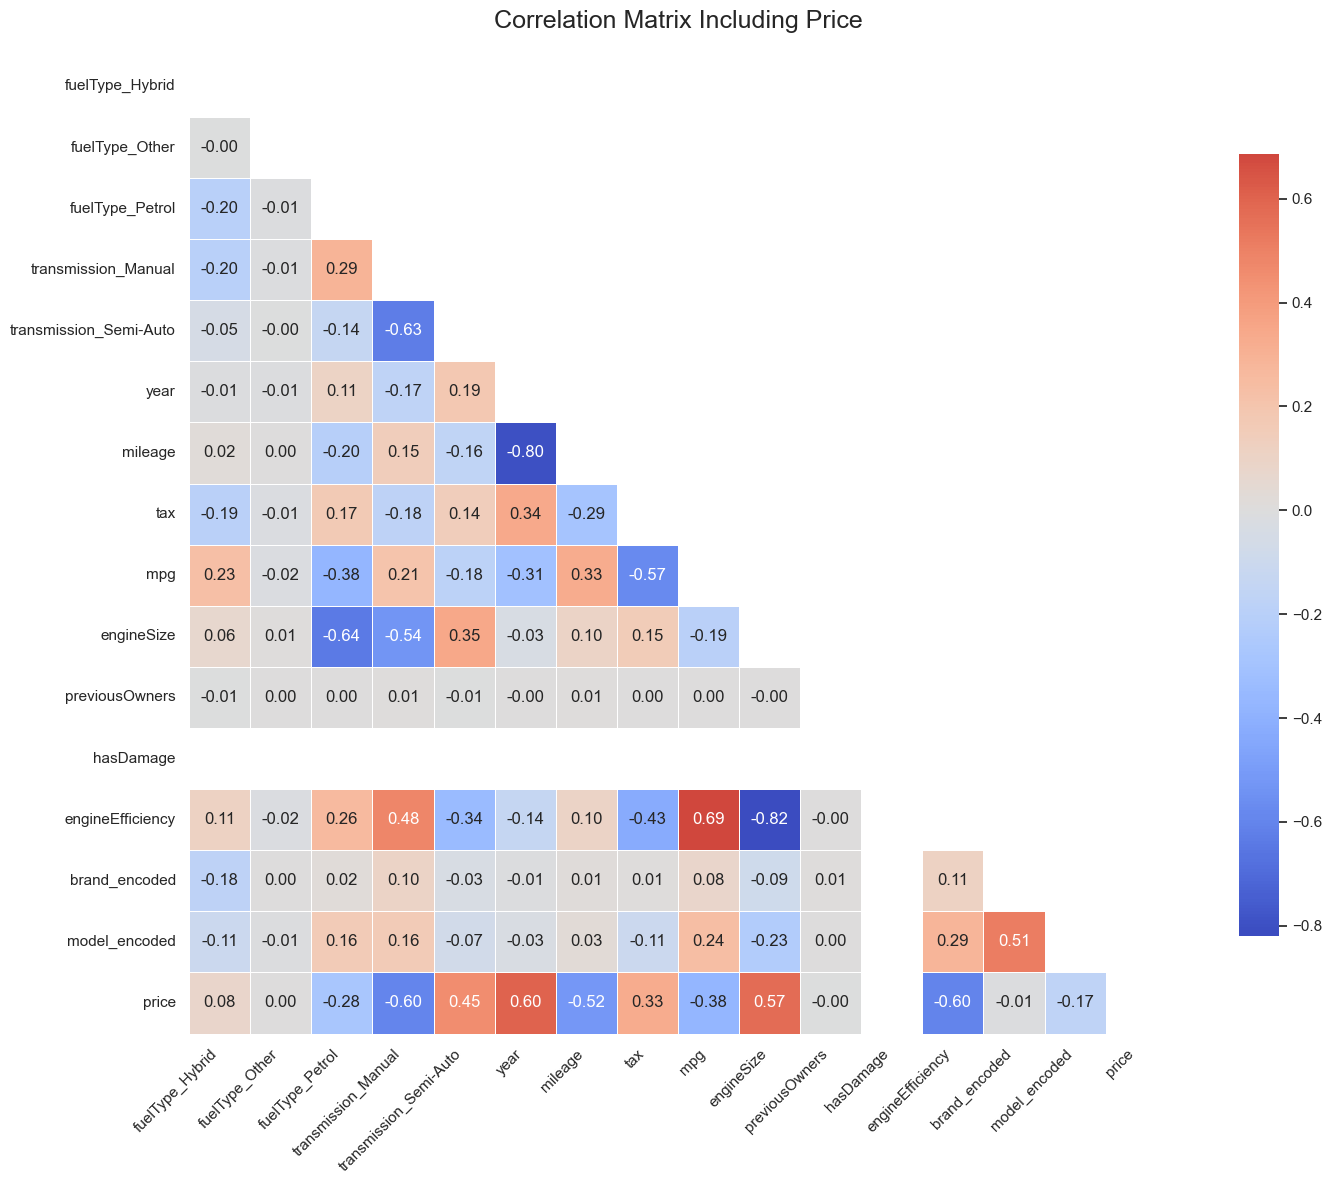

In [143]:
# Create mask for upper triangle
mask = np.triu(np.ones_like(cor_spearman, dtype=bool))

# White style
sns.set_theme(style="white")

# Plot
plt.figure(figsize=(16, 12))

sns.heatmap(
    cor_spearman,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

plt.title("Correlation Matrix Including Price", fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

As already seen in data exploration, the only two couple of features that have a high correlation (<|0.8|) are *mileage* vs *year* and *engineEfficiency* vs *engineSize*, which present a negative correlation of -0.80 and -0.82, respectively. It is important to note that, even though, 
these correlations are usually a signal of redundance, all of them have good correlations with *price* (either positives or negatives correlations), and correlation matrixes only give information about linear relationships, which, as seen before, do not have a high predominance in our dataset. For that reason, according to this analysis, this variables should be kept in our model.  
In addition, *previousOwners*, *hasDamaged* and *fuelType_Other* has no correlation or very few correlation with other variables, including *price*. 
This indicates these features are not relevant to predict our target.
Therefore, according to this method, all variables should be kept except for **hasDamaged** and **fuelType_Other** and **previousOwners**.

##### 4.10.1.3. Mutual Information (MI)

In [144]:
mi_scores = mutual_info_regression(X_train, y_train, random_state=0)

mi_df = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

print(mi_df.head(10))

top_mi_features = mi_df.head(15)['Feature']
X_train_mi = X_train[top_mi_features]

                   Feature  MI_Score
12        engineEfficiency  0.723694
14           model_encoded  0.619235
8                      mpg  0.408685
9               engineSize  0.391306
5                     year  0.335376
13           brand_encoded  0.325429
6                  mileage  0.294960
7                      tax  0.232182
3      transmission_Manual  0.228409
4   transmission_Semi-Auto  0.137316


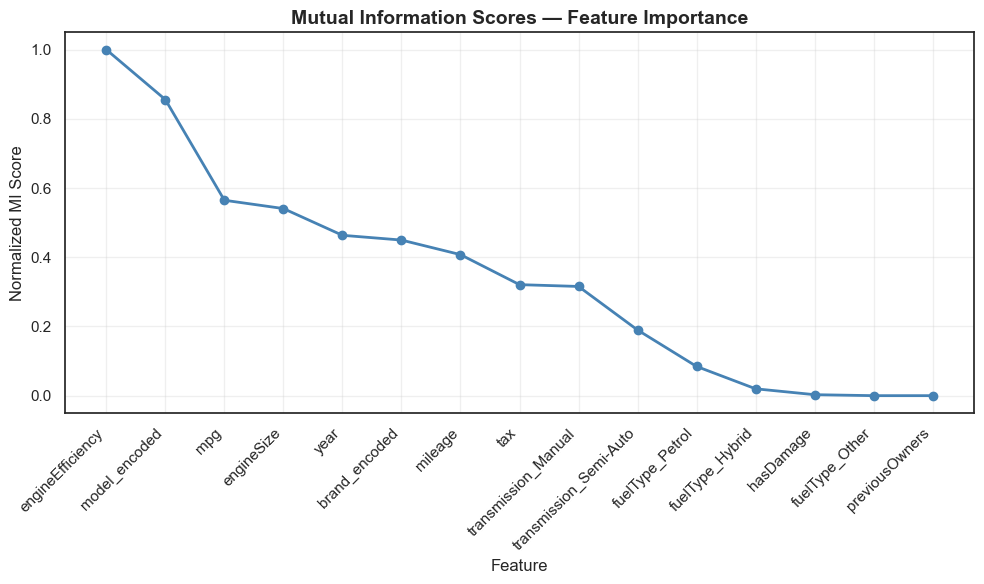

In [145]:
mi_df = mi_df.sort_values(by='MI_Score', ascending=False).reset_index(drop=True)
mi_df['MI_Score_norm'] = mi_df['MI_Score'] / mi_df['MI_Score'].max()

# Plot clean MI curve
plt.figure(figsize=(10, 6))
plt.plot(mi_df['Feature'], mi_df['MI_Score_norm'], marker='o', color='steelblue', linewidth=2)
plt.title("Mutual Information Scores — Feature Importance", fontsize=14, fontweight='bold')
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Normalized MI Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

tirar:
- fuelType_Other
- hasDamage
- previousOwners
- tax
- transmission_Manual
- fuelType_Hybrid
- transmission_Semi-Auto
- fuelType_Petrol

Considering that *Spearman Correlation Matrix* only analysis linear relationships, we have decided to perform the *Mutual Information (MI)* that gives us information about nonlinear predictive power of features. 
The MI scores show that *engineEfficiency* and *model_encode*d are the two most informative predictors, followed by *mpg*, *engineSize*, *year*, *brand_encoded* and *mileage*.
After the top 7 features, the MI values flatten considerably, indicating that additional variables give us little new information to predict *price*. 
Therefore, according to this method, the variables **previousOwners**, **fuelType_Other**, **hasDamaged**, **fuelType_Hybrid**, **fuelType_Petrol**, **transmission_Semi-Auto**, **transmission_manual** and **tax** should not be consider when training the model. 

#### 4.10.2. Wrapper Methods 
In addition to the filter methods, we also analysed wrapper methods that evaluate features based on actual model performances. In this way, we were able to detect interactions between features, since some of them may be considered weak alone but strong when combined, or redundant when another feature is present in the model. Here, we evaluated the sets of features based on *Root Mean Square Error (RMSQ)* that inform us how far off the model's predicted car prices are from the real prices, on average. That is the lower the value, the better the model is making predictions. 

##### 4.10.2.1. RFE

In [154]:
# Number of features to select

nof_list = np.arange(1, len(X_train.columns) + 1)
low_rmse = float('inf')  # NEW: Initialize comparison to infinity (high value)
# Variable to store the optimum features
nof = 0 
train_rmse_list = []      # NEW: Store RMSE instead of R-squared score
val_rmse_list = []        # NEW: Store RMSE instead of R-squared score

# --- RFE Loop using RMSE ---
for n in range(len(nof_list)):
    model = LinearRegression() # use LinearRegression as model
    
    # 1. Recursive Feature Elimination
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_val_rfe = rfe.transform(X_val)
    
    # 2. Train Model on Subset
    model.fit(X_train_rfe, y_train)
    
    # 3. Calculate and Store Training RMSE
    y_train_pred = model.predict(X_train_rfe)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_list.append(train_rmse)
    
    # 4. Calculate and Store Validation RMSE
    y_val_pred = model.predict(X_val_rfe)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_rmse_list.append(val_rmse)
    
    # 5. Check best score (finding the minimum RMSE)
    if(val_rmse <= low_rmse): # CHANGED: Look for the lowest RMSE (less than or equal)
        low_rmse = val_rmse
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("Lowest RMSE with %d features: %f" % (nof, low_rmse))

Optimum number of features: 13
Lowest RMSE with 13 features: 5012.959382


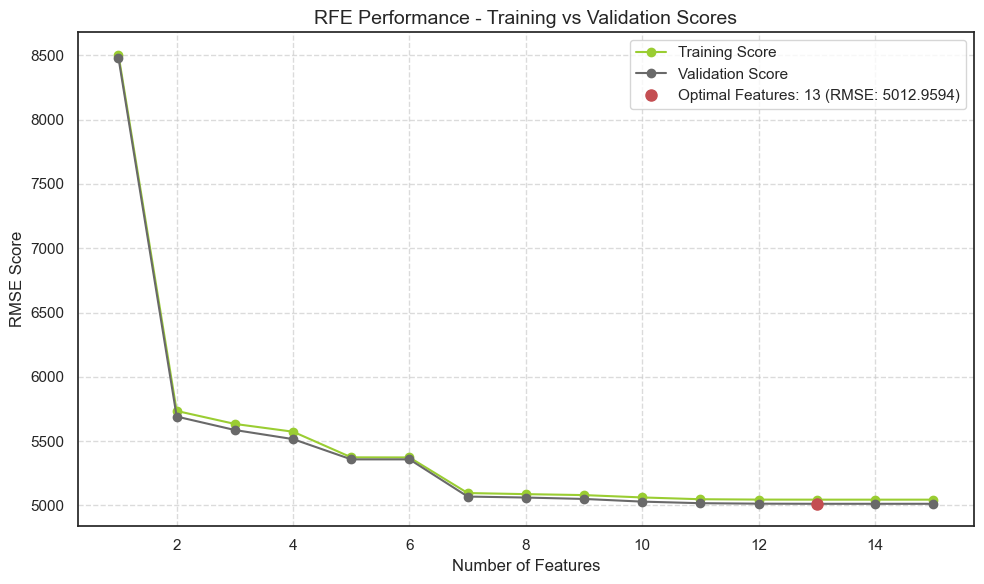

In [155]:
# Create plot to see RFE performance

x = np.arange(1, len(X_train.columns) + 1)

plt.figure(figsize=(10,6))
plt.plot(x, train_rmse_list, label='Training Score', color='yellowgreen', marker='o')
plt.plot(x, val_rmse_list, label='Validation Score', color='dimgray', marker='o')
plt.plot(nof, low_rmse, 'ro',label=f'Optimal Features: {nof} (RMSE: {low_rmse:.4f})', markersize=8)
plt.xlabel("Number of Features", fontsize=12)
plt.ylabel("RMSE Score", fontsize=12)
plt.title("RFE Performance - Training vs Validation Scores", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [156]:
# Select features

final_model = LinearRegression()   # Use LinearRegression as model because we want to predict price which is a continuous variable
rfe_final = RFE(estimator=final_model, n_features_to_select=nof)
rfe_final.fit(X_train, y_train)    # Apply RFE to determine the best features in our dataset

# Get the mask of selected features
selected_features_11 = X_train.columns[rfe_final.support_]   # Obtain the best features

print("Selected features using RFE ({} features):".format(nof))
print(list(selected_features_11))

Selected features using RFE (13 features):
['fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol', 'transmission_Manual', 'transmission_Semi-Auto', 'year', 'mileage', 'tax', 'mpg', 'engineSize', 'engineEfficiency', 'brand_encoded', 'model_encoded']


##### 4.10.2.2. RFECV

In [157]:
# Combine train and validation datasets
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# Create a test fold index (-1 for train, 0 for validation)
test_fold = [-1] * len(X_train) + [0] * len(X_val)

print('Test fold: ', len(test_fold))
print('X_combined: ', len(X_combined))
print('y_combined: ', len(y_combined))

# Define the PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

Test fold:  75522
X_combined:  75522
y_combined:  75522


In [158]:
# preprune random forest

base_estimator = RandomForestRegressor(
    n_estimators=200,   # number of trees
    max_depth=10,
    min_samples_leaf = 4,
    max_features="sqrt",
    random_state=0,
    n_jobs=-1
)

In [159]:
# Find number of features
neg_mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# 3. Execute RFECV to find the optimal feature count based on Validation RMSE
# Using the balanced estimator for the primary optimization process.
rfecv_selector = RFECV(
    estimator=base_estimator, 
    step=1,
    cv=ps, # Uses the PredefinedSplit (X_val) for scoring
    scoring=neg_mse_scorer
)
rfecv_selector.fit(X_combined, y_combined)

# --- Define the range of features evaluated by RFECV (for the X-axis) ---
feature_counts_range = rfecv_selector.cv_results_['n_features']

# 4. Calculate Training RMSE for the plot (MANUAL LOOP CORRECTED)
# We calculate the Training score for each feature subset size determined by the ranking.
train_rmse_list = []
feature_ranking = rfecv_selector.ranking_

for n in feature_counts_range:
    # Identify the features selected at this step (rank <= n)
    selected_features_mask = feature_ranking <= n
    
    # Subset X_train using the mask, assuming X_train is a Pandas DataFrame.
    X_train_subset = X_train.iloc[:, selected_features_mask]
    
    # Train on the SUBSET of features
    base_estimator.fit(X_train_subset, y_train)
    
    # Predict and calculate Training RMSE on the SUBSET of features
    train_pred = base_estimator.predict(X_train_subset)
    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse_list.append(np.sqrt(train_mse))


# 5. Prepare Plotting Data and Output
optimal_nof = rfecv_selector.n_features_
validation_scores_neg_mse = rfecv_selector.cv_results_['mean_test_score']
# Convert Validation Negative MSE scores to positive RMSE
validation_rmse = np.sqrt(-validation_scores_neg_mse) 
# The index of the optimal number of features is optimal_nof - 1
min_rmse = validation_rmse[optimal_nof - 1] 

# Variables for Plotting
nof_list = feature_counts_range
val_rmse_list = validation_rmse
nof = optimal_nof
low_rmse = min_rmse

print("\n--- RFECV Results (Using Random Forest) ---")
print(f"Optimal number of features found: {nof}")
print(f"Minimum Validation RMSE achieved: {low_rmse:.4f}")


--- RFECV Results (Using Random Forest) ---
Optimal number of features found: 9
Minimum Validation RMSE achieved: 2940.5500


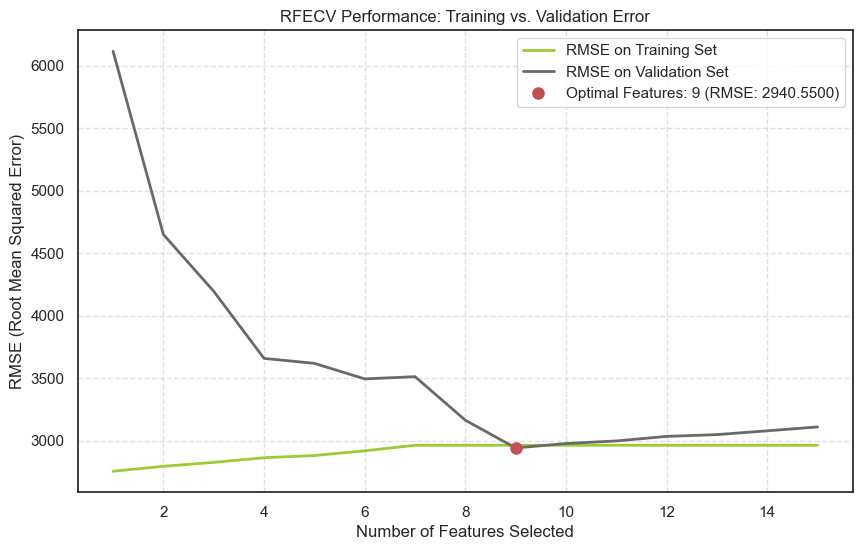

In [160]:
# Plot figure

plt.figure(figsize=(10, 6))

# Training RMSE (NEWLY ADDED)
plt.plot(nof_list, train_rmse_list,
         label="RMSE on Training Set", color='yellowgreen', linewidth=2) 
         
# Validation RMSE
plt.plot(nof_list, val_rmse_list, 
         label="RMSE on Validation Set", color='dimgray', linewidth=2) 

# Highlight the optimal point
plt.plot(nof, low_rmse, 'ro', 
         label=f'Optimal Features: {nof} (RMSE: {low_rmse:.4f})', markersize=8)

plt.xlabel("Number of Features Selected")
plt.ylabel("RMSE (Root Mean Squared Error)") 
plt.title("RFECV Performance: Training vs. Validation Error")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [152]:
# Get the mask of selected features (True for selected, False otherwise)
# rfecv_selector.support_ stores the mask corresponding to the optimal_nof
selected_feature_mask = rfecv_selector.support_

forward_features = X_train.columns[selected_feature_mask]

print("Selected features using RFECV ({} features):".format(optimal_nof))
print(list(forward_features))

Selected features using RFECV (9 features):
['transmission_Manual', 'year', 'mileage', 'tax', 'mpg', 'engineSize', 'engineEfficiency', 'brand_encoded', 'model_encoded']


According to *RFECV* with *Random Forest* as estimator, the optimal number of features to keep would be 9 as this combination of features reveal the lowest validation RMSE. The minimum score was 2940.5500, indicating that the model’s average prediction error is about £2940.
Therefore, according to this method, the variables to be discarded are **previousOwners**, **fuelType_Other**, **hasDamaged**, **fuelType_Hybrid**, **fuelType_Petrol**, **transmission_Semi-Auto**.

##### 4.10.2.1. Sequential Forward Feature Selection

In [153]:
from sklearn.feature_selection import SequentialFeatureSelector

#forward selection

sfs_forward = SequentialFeatureSelector(
    estimator=base_estimator,
    n_features_to_select="auto",   # Let SFS find optimal count
    direction="forward",
    scoring="neg_mean_squared_error",
    cv=ps,                          # small CV to reduce compute
    n_jobs=-1,
    tol=1e-3  
)

sfs_forward.fit(X_combined, y_combined)

# Selected feature mask and names
forward_mask = sfs_forward.get_support()
forward_features = X_train.columns[forward_mask]

print("Forward Selected Features:")
print(list(forward_features))

# Evaluate on validation set
base_estimator.fit(X_train[forward_features], y_train)
y_val_pred_forward = base_estimator.predict(X_val[forward_features])
val_rmse_forward = np.sqrt(mean_squared_error(y_val, y_val_pred_forward))

# Calculate Training RMSE 
y_train_pred_forward = base_estimator.predict(X_train[forward_features])
train_rmse_forward = np.sqrt(mean_squared_error(y_train, y_train_pred_forward))

print("Training RMSE (Forward SFS):", train_rmse_forward)
print("Validation RMSE (Forward SFS):", val_rmse_forward)

Forward Selected Features:
['year', 'engineSize', 'engineEfficiency', 'brand_encoded', 'model_encoded']
Training RMSE (Forward SFS): 2930.0413376984607
Validation RMSE (Forward SFS): 3000.1515819095857


In constract with *RFECV*, *Sequential Forward Feature Selection* stated that the optimal number of features would only be 5. The difference between training RMSE and validation RMSE is small, which means that the model does not overfit. When comparing the scores between RFECV and SFFS, the diference is not meaningful: SFFS has ~60 lower validation RMSE with 4 fewer features. 
Therefore, according to this method, the features that should be removed are **previousOwners**, **fuelType_Other**, **hasDamaged**, **fuelType_Hybrid**, **fuelType_Petrol**, **transmission_Semi-Auto**, **mpg**, **transmission_manual**, **tax** and **mileage**.

**Backward Selection**

In [161]:
# Backward Selection
sfs_backward = SequentialFeatureSelector(
    estimator=base_estimator,
    n_features_to_select="auto", # Let SFS find optimal count
    direction="backward",        # Key change for Backward Selection
    scoring="neg_mean_squared_error",
    cv=ps,                       # Use the same PredefinedSplit
    n_jobs=-1,
    tol=1e-3
)

sfs_backward.fit(X_combined, y_combined)

# Selected feature mask and names
backward_mask = sfs_backward.get_support()
backward_features = X_train.columns[backward_mask] 

print("\nBackward Selected Features:")
print(list(backward_features))

# Evaluate on validation set
# We must use a fresh fit of the base_estimator on the optimally selected features
base_estimator.fit(X_train[backward_features], y_train)
y_val_pred_backward = base_estimator.predict(X_val[backward_features])
val_rmse_backward = np.sqrt(mean_squared_error(y_val, y_val_pred_backward))

# Calculate Training RMSE 
y_train_pred_backward = base_estimator.predict(X_train[backward_features])
train_rmse_backward = np.sqrt(mean_squared_error(y_train, y_train_pred_backward))

print("Training RMSE (Backward SFS):", train_rmse_backward)
print("Validation RMSE (Backward SFS):", val_rmse_backward)



Backward Selected Features:
['fuelType_Petrol', 'transmission_Manual', 'year', 'mileage', 'mpg', 'engineSize', 'engineEfficiency', 'brand_encoded', 'model_encoded']
Training RMSE (Backward SFS): 2733.553936589603
Validation RMSE (Backward SFS): 2910.174872325108


#### 4.10.3. Embedded Methods 
As a way of complementing filter and wrapper methods, we have decided to also analyse some embedded methods since learn which features best contribute to the accuracy of the model while the model is being created. 

##### 4.10.3.1 Lasso 

In [166]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
#considering L1 Regularization

lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_train, y_train)

lasso_df = (
    pd.DataFrame({
        "feature": X_train.columns,
        "lasso_coef": lasso.coef_
    })
    .assign(abs_coef=lambda df: df['lasso_coef'].abs())
    .sort_values("abs_coef", ascending=False)
)

print("\n===== LASSO Feature Importance =====\n")
print(lasso_df[["feature", "lasso_coef"]])


===== LASSO Feature Importance =====

                   feature    lasso_coef
9               engineSize  54865.554570
8                      mpg -49835.947457
5                     year  35194.096749
12        engineEfficiency  29541.246165
1           fuelType_Other -13803.711024
6                  mileage -13466.858573
3      transmission_Manual  -3421.567201
0          fuelType_Hybrid   3005.530121
7                      tax  -1912.125144
13           brand_encoded   1583.223099
4   transmission_Semi-Auto   1212.847516
2          fuelType_Petrol   -489.470002
14           model_encoded   -306.740128
10          previousOwners     47.623671
11               hasDamage      0.000000


Unlikely wrapper methods, *Lasso* does not directly give us a set of optimal features, it applies L1 regularization, which forces some coefficients toward exactly zero. This means that, the closer a lasso coeficient is to zero, the more irrelevant a feature is. According to the coeficients, *engineSize*, *mpg* and *year* are the three features with strong relationship with price, while *hasDamaged*, *previousOwners* and *model_encoded* are the ones with minor importance. Our approach was to keep the features that have a lasso coeficient higher than |1500|, which represents a moderated coeficient. Therefore, based on this method, the features that should be removed are **previousOwners**, **hasDamaged**, **fuelType_Petrol**, **transmission_Semi-Auto**, **model_encoded**. 

##### 4.10.3.2. Random Forest Feature Importance 

In [167]:
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

rf_df = (
    pd.DataFrame({
        "feature": X_train.columns,
        "rf_importance": rf.feature_importances_
    })
    .sort_values("rf_importance", ascending=False)
)

print("\n===== Random Forest Feature Importance =====\n")
print(rf_df)


===== Random Forest Feature Importance =====

                   feature  rf_importance
3      transmission_Manual       0.291961
5                     year       0.193655
12        engineEfficiency       0.189172
9               engineSize       0.124943
6                  mileage       0.077390
14           model_encoded       0.050140
8                      mpg       0.026189
13           brand_encoded       0.024236
7                      tax       0.010439
10          previousOwners       0.005154
2          fuelType_Petrol       0.004594
4   transmission_Semi-Auto       0.001650
0          fuelType_Hybrid       0.000474
1           fuelType_Other       0.000003
11               hasDamage       0.000000


Unlikely wrapper methods, *Random Forest Feature Importance* does not directly give us a set of optimal features, it inform us how much each feature contributes to improving the model’s predictions by reducing the variance of the target variable (price). When analysing the output of *RFFI*, it is possible to understand that importance values are relative, all the features sum to 1.0. This indicates that, the features that contribute the most for model’s predictive power are *transmission_Manual*, *year* and *engineEfficiency* with 29%, 19.3% and 18.9%, respectively. According to this method, these are the features that are frequently used to split nodes across many trees and the one the model relies heavily on to make predictions. On the other hand, *hasDamaged*, *fuelType_Other* and *fuelType_Hybrid* are the features used very little (or not at all) in the trees, which means they do not reduce the variance of price significantly. In order to decide what features to keep or discard based on this method, our reference number was 0.01, since every feature whose importance is below this value, does not add enough information to the model. Thus, based on this method, every feature should be kept except for **previousOwners**, **hasDamaged**, **fuelType_Petrol**, **transmission_Semi-Auto**, **fuelType_Hybrid** and **fuelType_Other**. 

### Final Insights
Based on all the methods used and their individual conclusions, we have decided to build a table where for each feature, we analyse whether to keep or discard based on the method. Our approach to make this decision is based on whether the feature has 2 or more methods where was stated "discard". In case of having it 2 times, we would test the model with and without that feature, while the ones that have it more than 2 times would be automatically discarded. This implies that the features that have none or one "discard" are automatically included in the model. Moreover, considering that *RFECV* and *SFFS* are methods that provide an optimal number of features based on a specific set of variables, we have decided to also test the model with these groups of features, independently of the remain methods.  

| Predictor            | Variance | Spearman Correlation| Mutual Information | RFECV (Random Forest) | SFFS  | Lasso | RFFI | Decision              |
|----------------------|----------|---------------|---------------------|----------|------------------------|-------------|--------------|------------------------|
| *year*                 | Keep     | Keep           | Keep           | Keep     | Keep               | Keep        | Keep         | Include in the model   |
| *mileage*              | Keep     | Keep           | Keep           | Keep     | Discard            | Keep        | Keep         | Include in the model   |
| *tax*                  | Keep     | Keep           | Discard        | Keep     | Discard            | Keep        | Keep         | Try with and without   |
| *mpg*                  | Keep     | Keep           | Keep           | Keep     | Discard            | Keep        | Keep         | Include in the model   |
| *engineSize*           | Keep     | Keep           | Keep           | Keep     | Keep               | Keep        | Keep         | Include in the model   |
| *engineEfficiency*     | Keep     | Keep           | Keep           | Keep     | Keep               | Keep        | Keep         | Include in the model   |
| *brand_encoded*        | Keep     | Keep           | Keep           | Keep     | Keep               | Keep        | Keep         | Include in the model   |
| *model_encoded*        | Keep     | Keep           | Keep           | Keep     | Keep               | Discard     | Keep         | Include in the model   |
| *transmission_manual*  | Keep     | Keep           | Discard        | Keep     | Discard            | Keep        | Keep         | Try with and without |
| *transmission_Semi-Auto* | Keep   | Keep           | Discard        | Discard  | Discard            | Discard     | Discard      | Discard    |
| *fuelType_Hybrid*      | Keep     | Keep           | Discard        | Discard  | Discard            | Keep        | Discard      | Discard    |
| *fuelType_Petrol*      | Keep     | Keep           | Discard        | Discard  | Discard            | Discard     | Discard      | Discard    |
| *fuelType_Other*       | Discard  | Discard        | Discard        | Discard  | Discard            | Keep        | Discard      | Discard    |
| *previousOwners*       | Keep     | Discard        | Discard        | Discard  | Discard            | Discard     | Discard      | Discard    |
| *hasDamage*            | Discard  | Discard        | Discard        | Discard  | Discard            | Discard     | Discard      | Discard    |


Based on our strategy, we will test the model with the following sets of features: 
- *year*, *mileage*, *mpg*, *engineSize*, *engineEfficiency*, *brand_encoded*, *model_encoded*, *transmission_manual*, *tax*.
- *year*, *mileage*, *mpg*, *engineSize*, *engineEfficiency*, *brand_encoded*, *model_encoded*, *transmission_manual*
- *year*, *mileage*, *mpg*, *engineSize*, *engineEfficiency*, *brand_encoded*, *model_encoded*, *tax*.
- *year*, *engineSize*, *engineEfficiency*, *brand_encoded*, *model_encoded*.